In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
tqdm.pandas()
import matplotlib.pyplot as plt
%matplotlib inline

import os, gc, json
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sns.set(context='notebook', style='whitegrid', 
        palette='deep', font='sans-serif', 
        font_scale=2, color_codes=True, rc=None)

In [2]:
train = pd.read_csv('Dataset/train.csv')
test  = pd.read_csv('Dataset/test.csv')
sub   = pd.read_csv('Dataset/Sample_Submission.csv')

train.shape, test.shape, sub.shape

((5959, 3), (2553, 2), (5, 3))

In [3]:
train.rename(columns={'Review Text':'text', 'Review Title':'title'}, inplace=True)
test.rename(columns={'Review Text':'text', 'Review Title':'title'}, inplace=True)
test.columns, train.columns

(Index(['text', 'title'], dtype='object'),
 Index(['text', 'title', 'topic'], dtype='object'))

In [4]:
df = train.append(test, ignore_index=True)
df['save_text']  = df['text']
df['save_title'] = df['title']

df['text']  = df['text'].str.lower()
df['title'] = df['title'].str.lower()

In [5]:
with open('contraction_mapping.txt') as f:
    contraction_mapping = json.loads(f.read())

def correct_contraction(x, dic):
    for word in dic.keys():
        if word in x:
            x = x.replace(word, dic[word])
    return x

df['text']  = df['text'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))
df['title'] = df['title'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))


100%|██████████| 8512/8512 [00:00<00:00, 185786.85it/s]


In [6]:
import os,operator

with open('punctuation.txt', 'r') as f:
    extra_punct = json.loads(f.read())

import string
my_punct = list(string.punctuation)
all_punct = list(set(my_punct + extra_punct))

special_punc_mappings = {"—": "-", "–": "-", "_": "-", '”': '"', "″": '"', '“': '"', '•': '.', '−': '-',
                         "’": "'", "‘": "'", "´": "'", "`": "'", '\u200b': ' ', '\xa0': ' ','،':'','„':'',
                         '…': ' ... ', '\ufeff': ''}

def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    for punc in all_punct:
        if punc in text:
            text = text.replace(punc, f' {punc} ')
    return text

def clean_special_punctuations(text):
    for punc in special_punc_mappings:
        if punc in text:
#             print(punc)
            text = text.replace(punc, special_punc_mappings[punc])
    return text



def preprocess(text):
    text = spacing_punctuation(text)
    text = clean_special_punctuations(text)
    return text


df["text"] = df["text"].progress_apply(preprocess)
df['text'] = df['text'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['text'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['text'].replace({'  ':' '}, regex=True, inplace=True)

df["title"] = df["title"].progress_apply(preprocess)
df['title'] = df['title'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['title'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['title'].replace({'  ':' '}, regex=True, inplace=True)


100%|██████████| 8512/8512 [00:00<00:00, 159527.41it/s]


In [7]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

df['text']   = df['text'].progress_apply(clean_text)
df['title']  = df['title'].progress_apply(clean_text)

100%|██████████| 8512/8512 [00:00<00:00, 111426.07it/s]


In [8]:
def clean_text(x):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

df['text'] = df['text'].progress_apply(clean_text)
df['title'] = df['title'].progress_apply(clean_text)


100%|██████████| 8512/8512 [00:00<00:00, 139923.56it/s]


In [11]:
train1 = df[:train.shape[0]]
test1  = df[train.shape[0]:]
# train1.shape, test1.shape
train1.head()

,text,title,topic,save_text,save_title
0,did nothing for did not help lost even with wo...,useless,Shipment and delivery,"Did nothing for me, didn't help lost even with...",Useless
1,did nothing for did not help lost even with wo...,useless,Not Effective,"Did nothing for me, didn't help lost even with...",Useless
2,have bought these bags and immediately open on...,trash not buy these bags waist time,Customer Service,I have bought these bags and immediately open...,TRASH!!! Do not buy these bags it’s a waist of...
3,gave allergic reaction face,not recommend,Allergic,Gave me an allergic reaction on my face :(,Do not recommend
4,these not compare the name brand wipes family ...,cannot tackle big messes,Texture,These don't compare to the name brand wipes. F...,Can't tackle big messes


In [12]:
# train1.groupby(['text','title'])['topic'].apply(list)

In [9]:
# train1.groupby(['text','title']).agg(lambda x: tuple(x)).applymap(list).reset_index()

In [12]:
train1['topic'] = train1['topic'].apply(lambda x: "_".join(x.split(" ")))
gp = train1.groupby(['text','title']).agg({
        "topic": lambda x: " ".join(x.values)
    })
train2 = pd.DataFrame(gp.reset_index())

test1['topic'] = 'null'
gp = test1.groupby(['text','title']).agg({
        "topic": lambda x: " ".join(x.values)
    })
test2 = pd.DataFrame(gp.reset_index())

train2.head().append(test2.head())

,text,title,topic
0,,not working for,Not_Effective
1,about weeks after being these pills old boy st...,parents beware horrible stomach pain old,Ingredients Allergic
2,about year ago started drinking the amino ener...,the most disgusting tasting flavor have ever t...,Bad_Taste/Flavor Ingredients
3,absolutely awful disgusting avoid buying this,disgusting,Bad_Taste/Flavor
4,absolutely destroyed stomach horrible stomach ...,not for,Allergic
0,,the sellers did not ship timely and shipment g...,null
1,absolutely despised these vitamins wanted like...,nope nope nope,null null
2,absolutely disgusted the delivery was delivere...,delivery sucked,null null
3,absolutely terrible,gross,null
4,accidentally ordered the one made with sugar a...,sugarfree tastes better,null


In [13]:
train3 = pd.merge(train1[['text','title']], train2, how='left')
test3  = pd.merge(test1[['text','title']], test2, how='left')

train3['labels'] = train3['topic'].apply(lambda x: len(x.split(" ")))
test3['labels']  = test3['topic'].apply(lambda x: len(x.split(" ")))

train3.head().append(test3.head())

,text,title,topic,labels
0,did nothing for did not help lost even with wo...,useless,Shipment_and_delivery Not_Effective,2
1,did nothing for did not help lost even with wo...,useless,Shipment_and_delivery Not_Effective,2
2,have bought these bags and immediately open on...,trash not buy these bags waist time,Customer_Service,1
3,gave allergic reaction face,not recommend,Allergic,1
4,these not compare the name brand wipes family ...,cannot tackle big messes,Texture Quality/Contaminated Color_and_texture,3
0,use chia seed protein shakes these tasted like...,bad tast,null null,2
1,use chia seed protein shakes these tasted like...,bad tast,null null,2
2,not waste your money,change results,null,1
3,use the book fortify your life tieraona low do...,good vegan choice poor non vegan choice,null null,2
4,use the book fortify your life tieraona low do...,good vegan choice poor non vegan choice,null null,2


In [14]:
df1 = train2.append(test2, ignore_index=True)

print("Old table : ", df.shape, train.shape, test.shape) 
print("New Table : ", df1.shape, train2.shape, test2.shape)

Old table :  (8512, 5) (5959, 3) (2553, 2)
New Table :  (5983, 3) (4210, 3) (1773, 3)


In [15]:
labels = train1['topic'].values

train['target'] = train['topic'].astype('category').cat.codes
train['target'] = train['target'].astype('int')

def get_mapping(df, col_name):
    cat_codes = df[col_name].astype('category')
    
    class_mapping = {}
    i = 0
    for col in cat_codes.cat.categories:
        class_mapping[col] = i
        i += 1
    
    class_mapping_reverse = {}
    for key, value in class_mapping.items():
        class_mapping_reverse[value] = key

    return class_mapping, class_mapping_reverse

cl_map, cl_map_inv = get_mapping(train, 'topic')

In [16]:
cl_map1 = {}
for key, value in cl_map.items():
    cl_map1["_".join(key.split(" "))] = value
    
cl_map1

{'Allergic': 0,
 'Bad_Taste/Flavor': 1,
 'Color_and_texture': 2,
 'Customer_Issues': 3,
 'Customer_Service': 4,
 "Didn't_Like": 5,
 'Expiry': 6,
 'False_Advertisement': 7,
 'Hard_to_Chew': 8,
 'Inferior_to_competitors': 9,
 'Ingredients': 10,
 'Not_Effective': 11,
 'Packaging': 12,
 'Pricing': 13,
 'Quality/Contaminated': 14,
 'Shipment_and_delivery': 15,
 'Smells_Bad': 16,
 'Texture': 17,
 'Too_Sweet': 18,
 'Too_big_to_swallow': 19,
 'Wrong_Product_received': 20}

## `train2` and `test2` are multilabeled datset, whereas `train3` and `test3` are `merged` dataset with rows in order as that of original.

In [56]:
# df1['topic_list'] = df1['topic'].apply(lambda x: [i for i, key in enumerate(cl_map1.keys()) for xs in x.split(" ") if key in xs])

In [17]:
labels = train2['topic'].values
lt = np.zeros((df1.shape[0], 21))
j = -1
for key, value in cl_map1.items():
    j += 1
    for i, label in enumerate(labels):
#         print(label)
        if key in label:
            lt[i][j] = 1

print(lt.sum(axis=0))
l_table = pd.DataFrame(data=lt, columns=list(cl_map1.keys()))
l_table = l_table.astype('int')
print(l_table.shape)
l_table.head()

[ 567. 1192.  233.    8.  239.   31.  135.   37.    6.   44.  215.  605.
  466.  107.  712.  387.  123.  410.   97.  228.   99.]
(5983, 21)


,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


class count:  [1773 2907  959  277   53   11    3]
class wise:   [ 567 1194  234    8  239   31  136   37    6   44  216  611  467  107
  715  390  123  410   97  228   99]


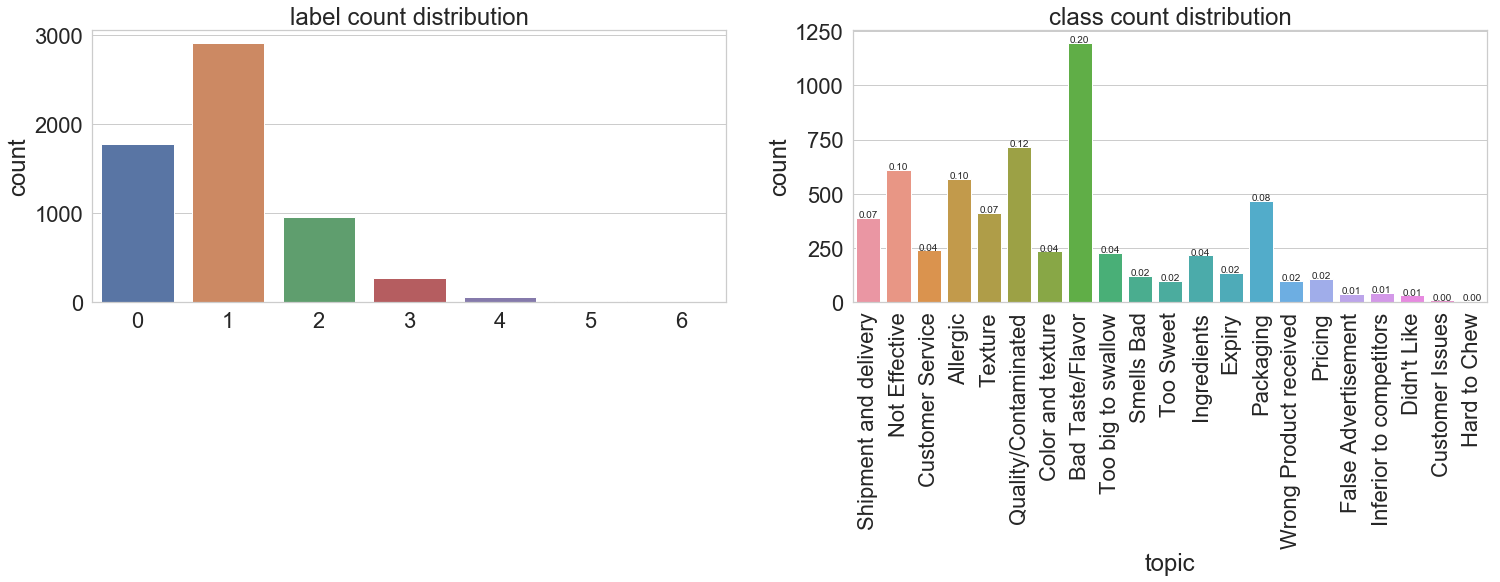

In [18]:
len1 = l_table.sum(axis=1)
fig, ax = plt.subplots(1,2,figsize=(25,5))
print("class count: ", np.bincount(len1))
print("class wise:  ", np.bincount(train['target']))

sns.countplot(len1, ax=ax[0])
ax[0].set_title("label count distribution")
sns.countplot(train['topic'], ax=ax[1])
ax[1].set_title("class count distribution")
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)
total = train.shape[0]
for p in ax[1].patches:
    height = p.get_height()
    ax[1].text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(height/total), ha="center") 
    

In [19]:
import gc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

def tfidf_feature(train, test, col_name, min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=120, decom_flag=False, which_method='svd', 
                  max_features=None, feat_col_name='svd'):
    """return tfidf feature
    Args:
        train, test: dataframe
        col_name: column name of text feature
        min_df: if Int, then it represent count of the minimum words in corpus (remove very rare word)
        analyzer: [‘word’, ‘char’]
        ngram: max range of ngram
        token_pattern: [using: r'\w{1,}'] [by default: '(?u)\b\w\w+\b']
        stopwords: ['english' or customized by remove specific words]
        n_component: n_component of svd feature transform
        decom_flag: Wheteher to run svd/nmf on top of that or not (by default: False)
        which_method: which to run [svd or nmf] on top of tfidf (by default: False)
        max_features: max no of features to keep, based on frequency. It will keep words with higher freq
    return:
        Transformed feature space of the text data, as well as tfidf function instance
        if svd_flag== True : train_tf, test_tf, tfv, svd
        else : train_tf, test_tf, tfv
    example:
        train_tfv, test_tfv, tfv = tfidf_feature(X_train, X_test, ['text'], min_df=3)
        train_svd, test_svd, complete_tfv, tfv, svd = tfidf_feature(X_train, X_test, ['text'], 
            min_df=3, svd_component=3, svd_flag=True)

    """
    tfv = TfidfVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, max_df=0.95, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                use_idf=1, smooth_idf=1, sublinear_tf=1,
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
#         return complete_df
#         print(complete_df.shape, complete_df.columns)

    tfv.fit(list(complete_df[:].values))

    if decom_flag is False:
        train_tfv =  tfv.transform(train[col_name].values.ravel()) 
        test_tfv  = tfv.transform(test[col_name].values.ravel())

        del complete_df
        gc.collect()
        return train_tfv, test_tfv, tfv
    else:
        complete_tfv = tfv.transform(complete_df[:].values.ravel())
        
        if which_method is 'svd':
            svd = TruncatedSVD(n_components=n_component)
            svd.fit(complete_tfv)
            complete_dec = svd.transform(complete_tfv)
        else:
            nmf = NMF(n_components=n_component, random_state=1234, alpha=0, l1_ratio=0)
            nmf.fit(complete_tfv)            
            complete_dec = nmf.fit_transform(complete_tfv)            
        
        
        complete_dec = pd.DataFrame(data=complete_dec)
        complete_dec.columns = [feat_col_name+'_'+str(i) for i in range(n_component)]

        train_dec = complete_dec.iloc[:train.shape[0]]
        test_dec = complete_dec.iloc[train.shape[0]:].reset_index(drop=True)

        del complete_dec, complete_df
        gc.collect()
        print("="*15, " done ", "="*15)
        return train_dec, test_dec, complete_tfv, tfv

def countvect_feature(train, test, col_name, min_df=3, 
                      analyzer='word', token_pattern=r'\w{1,}', 
                      ngram=3, stopwords='english', max_features=None):
    """return CountVectorizer feature
    Args:
        train, test: dataset
        col_name: columns name of the text feature
        min_df: if Int, then it represent count of the minimum words in corpus (remove very rare word)
        analyzer: [‘word’, ‘char’]
        ngram: max range of ngram
        token_pattern: [using: r'\w{1,}'] [by default: '(?u)\b\w\w+\b']
        stopwords: ['english' or customized by remove specific words]
        max_features: max no of features to keep, based on frequency. It will keep words with higher freq
    return:
        Count feature space of the text data, as well as its function instance
    """
    ctv = CountVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
    ctv.fit(list(complete_df[:].values))

    train_tf =  ctv.transform(train[col_name].values.ravel()) 
    test_tf  = ctv.transform(test[col_name].values.ravel())

    del complete_df
    gc.collect()
    return train_tf, test_tf, ctv


In [20]:
def get_count_vectorizer(df, col_name, min_df=3, analyzer='word', stopwords='english', 
                     token_pattern=r'\w{1,}', ngram=3, max_features=None):
    ctv = CountVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                stop_words = stopwords)

    ctv.fit(list(df[col_name].values))

    df_new =  ctv.transform(df[col_name].values.ravel()) 
    return df_new


def get_tfidf_feature(df, col_name, min_df=3, analyzer='word', stopwords='english',
                  token_pattern=r'\w{1,}', ngram=3, max_features=None):

    tfv = TfidfVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, max_df=0.95, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                use_idf=1, smooth_idf=1, sublinear_tf=1,
                stop_words = stopwords)

    tfv.fit(list(df[col_name].values))
    df_new =  tfv.transform(df[col_name].values.ravel()) 
    
    return df_new

In [62]:
print("="*15, "count-vect","="*15)
print("="*15, "text","="*15)
cvect_text_store = []
for ngram in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
#     if ngram < 11 : continue
    cvect = get_count_vectorizer(df1, 'text', ngram)
    print(cvect.shape)
    cvect_text_store.append(cvect)

print("="*15, "title","="*15)
cvect_title_store = []
for ngram in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
#     if ngram < 11 : continue
    cvect = get_count_vectorizer(df1, 'title', ngram)
    print(cvect.shape)
    cvect_title_store.append(cvect)
    
print("="*30)    
print("="*15, "tfidf","="*15)
print("="*15, "text","="*15)

tfidf_text_store = []
for ngram in [1,2,3,4,5,6,7,8,9,10]:
    tfidf = get_tfidf_feature(df1, 'text', ngram=ngram)
    print(tfidf.shape)
    tfidf_text_store.append(tfidf)
    
print("="*15, "title","="*15)
tfidf_title_store = []
for ngram in [1,2,3,4,5,6,7,8,9,10]:
    tfidf = get_tfidf_feature(df1, 'text', ngram=ngram)
    print(tfidf.shape)
    tfidf_title_store.append(tfidf)

=============== count-vect ===============
=============== text ===============
(5983, 190846)
(5983, 18056)
(5983, 8630)
(5983, 5692)
(5983, 4380)
(5983, 3491)
(5983, 2953)
(5983, 2584)
(5983, 2267)
(5983, 2056)
(5983, 1872)
(5983, 1716)
(5983, 1594)
(5983, 1499)
(5983, 1407)
=============== title ===============
(5983, 14131)
(5983, 2151)
(5983, 1259)
(5983, 877)
(5983, 702)
(5983, 572)
(5983, 489)
(5983, 439)
(5983, 383)
(5983, 336)
(5983, 304)
(5983, 280)
(5983, 259)
(5983, 233)
(5983, 215)
=============== tfidf ===============
=============== text ===============
(5983, 3684)
(5983, 8192)
(5983, 8630)
(5983, 8702)
(5983, 8750)
(5983, 8791)
(5983, 8829)
(5983, 8864)
(5983, 8896)
(5983, 8926)
=============== title ===============
(5983, 3684)
(5983, 8192)
(5983, 8630)
(5983, 8702)
(5983, 8750)
(5983, 8791)
(5983, 8829)
(5983, 8864)
(5983, 8896)
(5983, 8926)


In [252]:
for i, data in enumerate(count_vect_text):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
    print('count-vect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))


NameError: name 'count_vect_text' is not defined

In [63]:
train.shape, train1.shape, train2.shape, l_table.shape, df1.shape

((5959, 4), (5959, 5), (4210, 3), (5983, 21), (5983, 4))

In [258]:
# target_topic = target_['topic']
# target_.drop('topic', axis=1, inplace=True)

In [261]:
# l_table_topic = l_table['topic']
# l_table.drop('topic', axis=1, inplace=True)

,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0.890604,0.805369,0.952349,0.997315,0.948322,0.994631,0.977181,0.989933,0.997315,0.989262,0.954362,0.876510,0.911409,0.979866,0.826846,0.934228,0.975839,0.911409,0.981208,0.962416,0.981879
1,0.914765,0.810738,0.957718,0.997315,0.954362,0.989933,0.975839,0.992617,0.997315,0.989933,0.958389,0.889933,0.931544,0.975839,0.879866,0.946309,0.969128,0.926174,0.975168,0.966443,0.981879
2,0.912081,0.820134,0.959060,0.998658,0.957047,0.994631,0.980537,0.989933,0.997987,0.991946,0.953020,0.891275,0.926174,0.981208,0.877852,0.932215,0.977852,0.930201,0.976510,0.961074,0.985235
3,0.903356,0.810738,0.961074,0.998658,0.951678,0.993289,0.985906,0.993289,0.997315,0.989933,0.951678,0.896644,0.916779,0.981208,0.869799,0.934899,0.977852,0.928859,0.985235,0.961074,0.980537
4,0.899329,0.819463,0.953020,0.998658,0.938255,0.994631,0.975839,0.992617,0.996644,0.991946,0.961745,0.886577,0.898658,0.981208,0.849664,0.928188,0.977181,0.920134,0.981208,0.959060,0.985906
5,0.902685,0.824832,0.946309,0.998658,0.940940,0.993289,0.983893,0.991946,0.998658,0.991946,0.955034,0.870470,0.920134,0.977852,0.875168,0.924832,0.976510,0.924161,0.977181,0.960403,0.981879
6,0.887919,0.831544,0.944295,0.997315,0.940268,0.993289,0.979195,0.992617,0.998658,0.989933,0.947651,0.885235,0.902685,0.979866,0.869128,0.913423,0.975168,0.921477,0.978523,0.961074,0.981879
7,0.891946,0.820134,0.935570,0.998658,0.934228,0.994631,0.974497,0.989262,0.997987,0.991275,0.950336,0.888591,0.906711,0.977181,0.864430,0.897987,0.972483,0.917450,0.980537,0.957718,0.981879
8,0.913423,0.820134,0.954362,0.998658,0.932886,0.993289,0.976510,0.989933,0.998658,0.991275,0.947651,0.896644,0.886577,0.979866,0.864430,0.912081,0.975168,0.914094,0.977181,0.953691,0.975839
9,0.882550,0.836913,0.940940,0.998658,0.940940,0.994631,0.975839,0.992617,0.997987,0.991275,0.950336,0.895973,0.902685,0.976510,0.863758,0.908054,0.971141,0.930872,0.968456,0.959732,0.980537


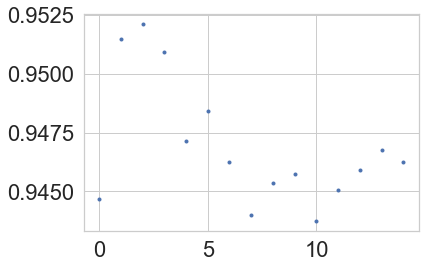

In [65]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split    

acc_table = []

for i, data in enumerate(cvect_text_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf = MultinomialNB().fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')
acc_table

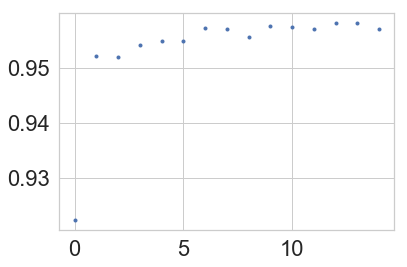

In [66]:
acc_table = []

for i, data in enumerate(cvect_title_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf = MultinomialNB().fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')

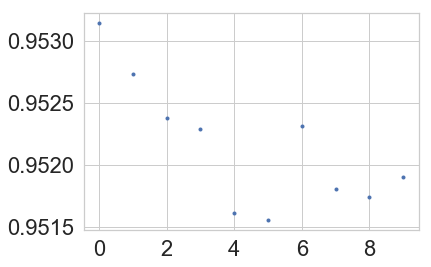

In [67]:
acc_table = []

for i, data in enumerate(tfidf_title_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf = MultinomialNB().fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')

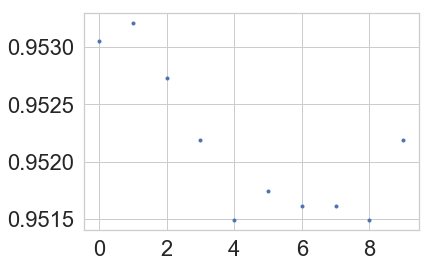

In [68]:
acc_table = []

for i, data in enumerate(tfidf_text_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf = MultinomialNB().fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')

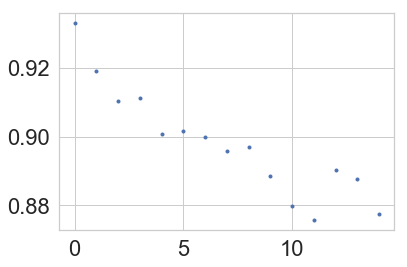

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(cvect_title_store):
    train_  = data[:train2.shape[0]]
    target_ = l_table[:train2.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')

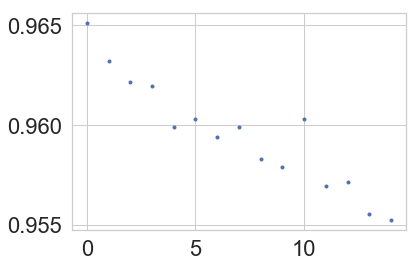

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(cvect_text_store):
    train_  = data[:train2.shape[0]]
    target_ = l_table[:train2.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')


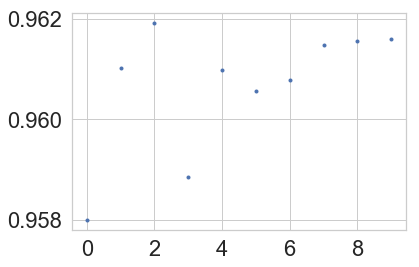

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(tfidf_text_store):
    train_  = data[:train2.shape[0]]
    target_ = l_table[:train2.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')


In [76]:
train2.shape, l_table.shape, data.shape

((4210, 3), (5983, 21), (5983, 8926))

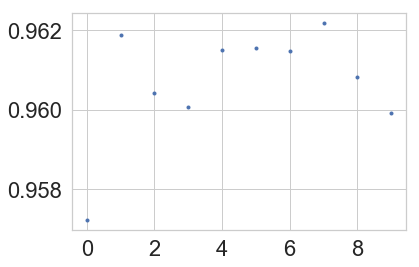

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(tfidf_title_store):
    train_  = data[:train2.shape[0]]
    target_ = l_table[:train2.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')


In [71]:
# # acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
# acc_table['overall'] = acc_table.apply(lambda x: np.mean(x), axis=1)
# acc_table = acc_table.reset_index()
# fig, ax = plt.subplots(1,1,figsize=(18, 5))
# sns.barplot(x='index',y='overall',data=acc_table, ax=ax)
# acc_table['overall']

In [274]:
test1['len'] = test1['topic'].apply(lambda x: len(x.split(" ")))

In [275]:
topic_len = test1['len']

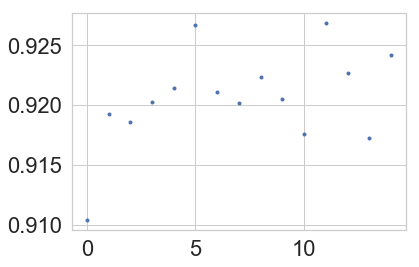

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

acc_table = []
preds = []
clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                        max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                        random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                        early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                        class_weight='balanced', warm_start=False, average=False, n_iter=1000)

for i, data in enumerate(cvect_text_store):
    train_  = data[:train2.shape[0]]
    target_ = l_table[:train2.shape[0]]
#     test_   = data[train2.shape[0]:]
    
    
    accs = []
    for cls in target_.columns:
        if(cls == 'topic'): continue
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
#         pred = clf.predict_proba(test_)
#         print(cls)
#         preds.append(pred[:,1])
    acc_table.append(accs)
    
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')


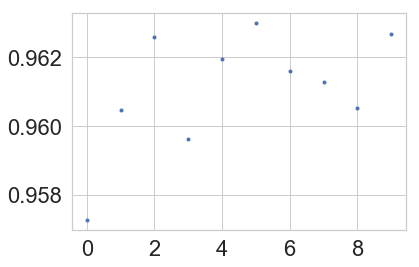

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

acc_table = []
preds = []
clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                        max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                        random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                        early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                        class_weight='balanced', warm_start=False, average=False, n_iter=1000)

for i, data in enumerate(tfidf_text_store):
    train_  = data[:train2.shape[0]]
    target_ = l_table[:train2.shape[0]]
#     test_   = data[train2.shape[0]:]
    
    
    accs = []
    for cls in target_.columns:
        if(cls == 'topic'): continue
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
#         pred = clf.predict_proba(test_)
#         print(cls)
#         preds.append(pred[:,1])
    acc_table.append(accs)
    
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')


In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

acc_table = []
preds = []
clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.2, fit_intercept=True, 
                        max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                        random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                        early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                        class_weight='balanced', warm_start=False, average=False, n_iter=1000)

for i, data in enumerate(tfidf_text_store):
    train_  = data[:train2.shape[0]]
    target_ = l_table[:train2.shape[0]]
    test_   = data[train2.shape[0]:]
    
    
    accs = []
    for cls in target_.columns:
        if(cls == 'topic'): continue
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
        pred = clf.predict_proba(test_)
#         print(cls)
        preds.append(pred[:,1])
#     acc_table.append(accs)
    break
    
    
# acc_table.columns = l_table.columns
# acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
# plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')


In [89]:
preds

[array([0.16886572, 0.24667173, 0.06420446, ..., 0.03623165, 0.10125708,
        0.03596829]),
 array([0.16317266, 0.42567895, 0.16133415, ..., 0.22174593, 0.99133979,
        0.99693953]),
 array([0.03866541, 0.56926395, 0.02923402, ..., 0.02173836, 0.0315769 ,
        0.73789252]),
 array([1.41312378e-02, 4.80667240e-07, 4.73423138e-02, ...,
        6.64786977e-12, 4.53587599e-08, 4.65272830e-02]),
 array([0.07877521, 0.01872314, 0.2009203 , ..., 0.24490697, 0.0426402 ,
        0.01166301]),
 array([1.51384187e-03, 2.47755526e-03, 1.05528560e-03, ...,
        6.15882644e-04, 2.04225581e-05, 8.89650638e-05]),
 array([0.03818556, 0.00718595, 0.05399064, ..., 0.01934012, 0.02023644,
        0.00357394]),
 array([1.11187020e-02, 5.47435349e-05, 7.97729644e-02, ...,
        2.31387660e-04, 1.30500988e-04, 7.48476648e-05]),
 array([8.83079059e-02, 4.44274325e-07, 1.23816993e-03, ...,
        5.44012229e-10, 6.91714198e-06, 7.45193555e-09]),
 array([7.50112535e-03, 1.19155677e-06, 2.8781609

In [94]:
preds1 = np.array(preds).T
# np.argsort(preds1, axis=1)

In [95]:
np.argsort(preds1)

array([[ 5,  9,  7, ...,  1,  0, 11],
       [ 8,  3,  9, ..., 18,  1,  2],
       [ 9,  5,  8, ...,  1,  4, 15],
       ...,
       [ 3,  8,  7, ...,  1,  4, 11],
       [ 3,  8,  9, ..., 14, 11,  1],
       [ 8,  9,  7, ..., 14,  2,  1]])

In [97]:
train2['topic_len'] = train2['topic'].apply(lambda x: len(x.split(" ")))

In [98]:
train2

,text,title,topic,topic_len
0,,not working for,Not_Effective,1
1,about weeks after being these pills old boy st...,parents beware horrible stomach pain old,Ingredients Allergic,2
2,about year ago started drinking the amino ener...,the most disgusting tasting flavor have ever t...,Bad_Taste/Flavor Ingredients,2
3,absolutely awful disgusting avoid buying this,disgusting,Bad_Taste/Flavor,1
4,absolutely destroyed stomach horrible stomach ...,not for,Allergic,1
5,absolutely did not improve health all any way ...,useless product,Not_Effective,1
6,absolutely did not work took four and still sl...,did not work for,Not_Effective,1
7,absolutely disgusting this has the worst after...,terrible stay away,Bad_Taste/Flavor,1
8,absolutely hate the size this enormous horse p...,never again,Too_big_to_swallow,1
9,absolutely horrible did not work even with tak...,waste money with return available,Not_Effective,1


In [180]:
test2.drop(['final','final1'], axis=1, inplace=True)

In [183]:
test2['topic_len'] = test2['topic'].apply(lambda x: len(x.split(" ")))

In [184]:
topic_len = test2['topic_len']
preds_final = []
for pred, len_ in zip(preds1, topic_len):
    high = np.argsort(pred)[-len_:]

    preds_final.append(high)
#     preds_final.append(np.repeat(high, len_))
    

In [185]:
preds_final

[array([11]),
 array([1, 2]),
 array([ 4, 15]),
 array([12]),
 array([3]),
 array([0]),
 array([11,  6]),
 array([11, 17, 14, 12]),
 array([0]),
 array([11,  0]),
 array([ 0, 14]),
 array([7]),
 array([14,  1, 11]),
 array([1, 0]),
 array([1]),
 array([12]),
 array([0]),
 array([0]),
 array([6]),
 array([11]),
 array([14]),
 array([1]),
 array([5]),
 array([16]),
 array([1]),
 array([8]),
 array([3]),
 array([3]),
 array([20]),
 array([3]),
 array([14]),
 array([12]),
 array([8, 1]),
 array([ 1, 18]),
 array([19,  1]),
 array([11]),
 array([12]),
 array([0]),
 array([17]),
 array([1]),
 array([ 1, 17]),
 array([11,  1]),
 array([15, 16]),
 array([ 1, 18, 17]),
 array([1]),
 array([ 1, 14]),
 array([ 1, 14]),
 array([17,  1,  0, 14]),
 array([ 1, 14]),
 array([ 0, 14]),
 array([ 0, 14]),
 array([ 1, 18, 14]),
 array([11, 14]),
 array([12, 11]),
 array([15]),
 array([11]),
 array([17,  2,  1]),
 array([11,  0]),
 array([11]),
 array([ 0, 14,  1, 10]),
 array([11]),
 array([11,  3]),
 arr

In [102]:
np.array(preds).T.shape, test2.shape

((1773, 21), (1773, 3))

In [283]:
preds = np.array(preds)
preds

array([[1.96409578e-01, 2.30484153e-05, 8.48905141e-02, ...,
        8.29280824e-02, 1.99686281e-01, 1.53855245e-01],
       [5.67328076e-01, 6.01306670e-04, 5.35583302e-01, ...,
        9.28365557e-01, 2.51059346e-01, 1.14126888e-01],
       [1.02439521e-01, 3.09886675e-04, 5.83075852e-02, ...,
        1.30731623e-01, 1.05649094e-01, 3.82157622e-02],
       ...,
       [7.24191859e-02, 5.59979491e-05, 1.03122419e-02, ...,
        3.90416734e-02, 9.76567893e-02, 2.81227822e-02],
       [4.93076129e-02, 3.76096633e-04, 3.44701696e-01, ...,
        9.34185307e-02, 1.19781654e-01, 3.95687691e-02],
       [4.16788535e-02, 9.99999997e-01, 5.20386254e-01, ...,
        3.46782513e-02, 1.03607298e-01, 7.28002427e-02]])

In [284]:
l_table.columns

Index(['Allergic', 'Bad_Taste/Flavor', 'Color_and_texture', 'Customer_Issues',
       'Customer_Service', 'Didn't_Like', 'Expiry', 'False_Advertisement',
       'Hard_to_Chew', 'Inferior_to_competitors', 'Ingredients',
       'Not_Effective', 'Packaging', 'Pricing', 'Quality/Contaminated',
       'Shipment_and_delivery', 'Smells_Bad', 'Texture', 'Too_Sweet',
       'Too_big_to_swallow', 'Wrong_Product_received'],
      dtype='object')

In [285]:
# preds.shape, l_table.shape
# preds = preds.T
# preds = pd.DataFrame(data=l_table, columns=l_table.columns)
# preds

,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [286]:
preds['topic'] = preds.apply(lambda x: [i for i, xs in enumerate(x) if xs is 1], axis=1)


In [186]:
preds_final = [list(x) for x in preds_final]
test2['final'] = np.array(preds_final)
test2

,text,title,topic,topic_len,final
0,,the sellers did not ship timely and shipment g...,null,1,[11]
1,absolutely despised these vitamins wanted like...,nope nope nope,null null,2,"[1, 2]"
2,absolutely disgusted the delivery was delivere...,delivery sucked,null null,2,"[4, 15]"
3,absolutely terrible,gross,null,1,[12]
4,accidentally ordered the one made with sugar a...,sugarfree tastes better,null,1,[3]
5,after hour taking this had the worst tunnel vi...,tunnel vision and felt like head was vice,null,1,[0]
6,after months being stored the proper temperatu...,discolored,null null,2,"[11, 6]"
7,after much trepidation bought this bottle has ...,aware fake scam,null null null null,4,"[11, 17, 14, 12]"
8,after taking for successive days have very ter...,terrible side effects,null,1,[0]
9,after taking this since february this product ...,bad stomach pains cannot return upset,null null,2,"[11, 0]"


In [105]:
cl_map1

{'Allergic': 0,
 'Bad_Taste/Flavor': 1,
 'Color_and_texture': 2,
 'Customer_Issues': 3,
 'Customer_Service': 4,
 "Didn't_Like": 5,
 'Expiry': 6,
 'False_Advertisement': 7,
 'Hard_to_Chew': 8,
 'Inferior_to_competitors': 9,
 'Ingredients': 10,
 'Not_Effective': 11,
 'Packaging': 12,
 'Pricing': 13,
 'Quality/Contaminated': 14,
 'Shipment_and_delivery': 15,
 'Smells_Bad': 16,
 'Texture': 17,
 'Too_Sweet': 18,
 'Too_big_to_swallow': 19,
 'Wrong_Product_received': 20}

In [187]:
test2['final1'] = test2['final'].apply(lambda x: list(cl_map_inv[xs] for xs in x))
test2

,text,title,topic,topic_len,final,final1
0,,the sellers did not ship timely and shipment g...,null,1,[11],[Not Effective]
1,absolutely despised these vitamins wanted like...,nope nope nope,null null,2,"[1, 2]","[Bad Taste/Flavor, Color and texture]"
2,absolutely disgusted the delivery was delivere...,delivery sucked,null null,2,"[4, 15]","[Customer Service, Shipment and delivery]"
3,absolutely terrible,gross,null,1,[12],[Packaging]
4,accidentally ordered the one made with sugar a...,sugarfree tastes better,null,1,[3],[Customer Issues]
5,after hour taking this had the worst tunnel vi...,tunnel vision and felt like head was vice,null,1,[0],[Allergic]
6,after months being stored the proper temperatu...,discolored,null null,2,"[11, 6]","[Not Effective, Expiry]"
7,after much trepidation bought this bottle has ...,aware fake scam,null null null null,4,"[11, 17, 14, 12]","[Not Effective, Texture, Quality/Contaminated,..."
8,after taking for successive days have very ter...,terrible side effects,null,1,[0],[Allergic]
9,after taking this since february this product ...,bad stomach pains cannot return upset,null null,2,"[11, 0]","[Not Effective, Allergic]"


In [114]:
test1 = test1.reset_index(drop=True)
final_test = pd.merge(test1, test2, how='left', on='text')
final_test.head()

,text,title_x,topic_x,save_text,save_title,title_y,topic_y,final,final1
0,use chia seed protein shakes these tasted like...,bad tast,null,I use chia seed in my protein shakes. These ta...,Bad tast,bad tast,null null,[1],[Bad Taste/Flavor]
1,use chia seed protein shakes these tasted like...,bad tast,null,I use chia seed in my protein shakes. These ta...,Bad tast,bad tast,null null,[1],[Bad Taste/Flavor]
2,not waste your money,change results,null,Don’t waste your money.,No change. No results.,change results,null,"[1, 11]","[Bad Taste/Flavor, Not Effective]"
3,use the book fortify your life tieraona low do...,good vegan choice poor non vegan choice,null,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",good vegan choice poor non vegan choice,null null,[10],[Ingredients]
4,use the book fortify your life tieraona low do...,good vegan choice poor non vegan choice,null,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",good vegan choice poor non vegan choice,null null,[10],[Ingredients]


In [110]:
test2.final1.apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('final2')

,final2
0,Not Effective
1,Bad Taste/Flavor
1,Color and texture
2,Customer Service
2,Shipment and delivery
3,Packaging
4,Customer Issues
5,Allergic
6,Expiry
7,Packaging


In [289]:
topics_ = test1.final1.apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('final2')

In [290]:
test2  = test2.reset_index()
topics_= test2.final1.apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('final2').reset_index()
test3  = pd.merge(test2, topics_, how="right")
test3.shape

(2553, 8)

In [125]:
test2

,text,title,topic,final,final1
0,,the sellers did not ship timely and shipment g...,null,[11],[Not Effective]
1,absolutely despised these vitamins wanted like...,nope nope nope,null null,"[1, 2]","[Bad Taste/Flavor, Color and texture]"
2,absolutely disgusted the delivery was delivere...,delivery sucked,null null,"[4, 15]","[Customer Service, Shipment and delivery]"
3,absolutely terrible,gross,null,[12],[Packaging]
4,accidentally ordered the one made with sugar a...,sugarfree tastes better,null,[3],[Customer Issues]
5,after hour taking this had the worst tunnel vi...,tunnel vision and felt like head was vice,null,[0],[Allergic]
6,after months being stored the proper temperatu...,discolored,null null,[6],[Expiry]
7,after much trepidation bought this bottle has ...,aware fake scam,null null null null,[12],[Packaging]
8,after taking for successive days have very ter...,terrible side effects,null,[0],[Allergic]
9,after taking this since february this product ...,bad stomach pains cannot return upset,null null,[0],[Allergic]


In [198]:
texts_  = []
titles_ = []
finals_ = []
topic_lens = []
for row in test2.values:
    for topic in row[5]:
        texts_.append(row[0])
        titles_.append(row[1])
        finals_.append(topic)
        topic_lens.append(row[3])
        

In [205]:
final_sub = pd.DataFrame(data = np.vstack([texts_, titles_, topic_lens, finals_])).T
final_sub.columns = ['text1','title1','topic_len1','final1']
final_sub

,text1,title1,topic_len1,final1
0,,the sellers did not ship timely and shipment g...,1,Not Effective
1,absolutely despised these vitamins wanted like...,nope nope nope,2,Bad Taste/Flavor
2,absolutely despised these vitamins wanted like...,nope nope nope,2,Color and texture
3,absolutely disgusted the delivery was delivere...,delivery sucked,2,Customer Service
4,absolutely disgusted the delivery was delivere...,delivery sucked,2,Shipment and delivery
5,absolutely terrible,gross,1,Packaging
6,accidentally ordered the one made with sugar a...,sugarfree tastes better,1,Customer Issues
7,after hour taking this had the worst tunnel vi...,tunnel vision and felt like head was vice,1,Allergic
8,after months being stored the proper temperatu...,discolored,2,Not Effective
9,after months being stored the proper temperatu...,discolored,2,Expiry


In [211]:
final_sub1 = pd.merge(test1, final_sub, how='left', left_on=['text','title'], right_on=['text1','title1'])
final_sub1 = final_sub1.drop_duplicates()
final_sub1.reset_index(drop=True, inplace=True)

In [212]:
test1.shape, final_sub1.shape

((2553, 5), (2561, 9))

In [218]:
final_sub1 = final_sub1[['save_text','save_title','final1']].drop_duplicates()

In [217]:
test1

,text,title,topic,save_text,save_title
0,use chia seed protein shakes these tasted like...,bad tast,null,I use chia seed in my protein shakes. These ta...,Bad tast
1,use chia seed protein shakes these tasted like...,bad tast,null,I use chia seed in my protein shakes. These ta...,Bad tast
2,not waste your money,change results,null,Don’t waste your money.,No change. No results.
3,use the book fortify your life tieraona low do...,good vegan choice poor non vegan choice,null,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice"
4,use the book fortify your life tieraona low do...,good vegan choice poor non vegan choice,null,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice"
5,used loyal customer this brand have been using...,smell horrible,null,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!
6,used loyal customer this brand have been using...,smell horrible,null,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!
7,used loyal customer this brand have been using...,smell horrible,null,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!
8,used loyal customer this brand have been using...,smell horrible,null,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!
9,have not received yet,shipping,null,I haven’t received it yet.,Shipping


In [222]:
final_sub1.columns = sub.columns

In [223]:
final_sub1.to_csv('submission/multilabel_corrected.csv',index=None)

## only single label 

In [230]:
test2

,text,title,final2
0,,the sellers did not ship timely and shipment g...,Not Effective
1,absolutely despised these vitamins wanted like...,nope nope nope,Bad Taste/Flavor
2,absolutely disgusted the delivery was delivere...,delivery sucked,Customer Service
3,absolutely terrible,gross,Packaging
4,accidentally ordered the one made with sugar a...,sugarfree tastes better,Customer Issues
5,after hour taking this had the worst tunnel vi...,tunnel vision and felt like head was vice,Allergic
6,after months being stored the proper temperatu...,discolored,Not Effective
7,after much trepidation bought this bottle has ...,aware fake scam,Not Effective
8,after taking for successive days have very ter...,terrible side effects,Allergic
9,after taking this since february this product ...,bad stomach pains cannot return upset,Not Effective


In [233]:
# test2['final2'] = test2['final1'].apply(lambda x: x[0])
test2 = test2[['text','title','final2']]
final_sub_a = pd.merge(test1, test2, on=['text','title'], how='left')
final_sub_a.shape, test1.shape

((2553, 6), (2553, 5))

In [235]:
final_sub_a = final_sub_a[['save_text','save_title','final2']]
final_sub_a.columns = sub.columns
final_sub_a.to_csv('submission/multilabel_corrected2.csv',index=None)
final_sub_a.head()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
1,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Allergic
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Allergic


In [191]:
test22 = test2.copy()

test22.final1.apply(pd.Series) \
    .merge(test22, right_index = True, left_index = True) \
    .melt(id_vars = ['text', 'title', 'final','final1', 'topic_len'], value_name = "new") \
    .sort_values('text')

,text,title,variable,new
0,,the sellers did not ship timely and shipment g...,0,Not Effective
5319,,the sellers did not ship timely and shipment g...,3,NaN
8865,,the sellers did not ship timely and shipment g...,5,NaN
10638,,the sellers did not ship timely and shipment g...,topic,null
3546,,the sellers did not ship timely and shipment g...,2,NaN
12411,,the sellers did not ship timely and shipment g...,topic_len,1
14184,,the sellers did not ship timely and shipment g...,final,[11]
1773,,the sellers did not ship timely and shipment g...,1,NaN
15957,,the sellers did not ship timely and shipment g...,final1,[Not Effective]
7092,,the sellers did not ship timely and shipment g...,4,NaN


In [154]:
test2222 = test222.dropna(axis=0)
test2222['new1'] = test2222['new'].apply(lambda x: np.where(x.split(" ")[0] == 'null', 'NULL', x))
test2222 = test2222[test2222['new1'] != 'NULL']
test2222.shape

(2495, 8)

In [177]:
test2222.sort_values('text')

,index,text,title,final,final1,variable,new,new1
0,0,,the sellers did not ship timely and shipment g...,[11],[Not Effective],0,Not Effective,Not Effective
11,1774,absolutely despised these vitamins wanted like...,nope nope nope,"[1, 2]","[Bad Taste/Flavor, Color and texture]",1,Color and texture,Color and texture
13,1,absolutely despised these vitamins wanted like...,nope nope nope,"[1, 2]","[Bad Taste/Flavor, Color and texture]",0,Bad Taste/Flavor,Bad Taste/Flavor
17,2,absolutely disgusted the delivery was delivere...,delivery sucked,"[4, 15]","[Customer Service, Shipment and delivery]",0,Customer Service,Customer Service
16,1775,absolutely disgusted the delivery was delivere...,delivery sucked,"[4, 15]","[Customer Service, Shipment and delivery]",1,Shipment and delivery,Shipment and delivery
21,3,absolutely terrible,gross,[12],[Packaging],0,Packaging,Packaging
33,4,accidentally ordered the one made with sugar a...,sugarfree tastes better,[3],[Customer Issues],0,Customer Issues,Customer Issues
40,5,after hour taking this had the worst tunnel vi...,tunnel vision and felt like head was vice,[0],[Allergic],0,Allergic,Allergic
47,6,after months being stored the proper temperatu...,discolored,[6],[Expiry],0,Expiry,Expiry
52,7,after much trepidation bought this bottle has ...,aware fake scam,[12],[Packaging],0,Packaging,Packaging


In [165]:
test2222 = test2222.sort_values('index')
final_model = pd.merge(test1, test2222, how='left', on=['text','title'])

In [171]:
final_model = final_model[['save_text','save_title','new1']]
final_model

,save_text,save_title,new1
0,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
1,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
2,Don’t waste your money.,No change. No results.,Bad Taste/Flavor
3,Don’t waste your money.,No change. No results.,Not Effective
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
5,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
6,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!,Quality/Contaminated
7,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!,Quality/Contaminated
8,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!,Quality/Contaminated
9,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!,Quality/Contaminated


In [175]:
final_model.drop_duplicates().sort_values('save_text')

,save_text,save_title,new1
650,"""Stir for 30 seconds until product dissolves.""...",Does Not Dissolve,Allergic
651,"""Stir for 30 seconds until product dissolves.""...",Does Not Dissolve,Bad Taste/Flavor
2039,"""X Brand"" has failed to deliver what they offe...","The 3-pack does not come with 3, only 1.",Shipment and delivery
2038,"""X Brand"" has failed to deliver what they offe...","The 3-pack does not come with 3, only 1.",Packaging
2786,"""X Brand"" is screwing products. They sent hydr...",Screwed up,Wrong Product received
2433,"""X Brand"" needs to make sure the top is sealed...",Shipping Issues,Ingredients
263,*I bought this when I thought I ran out. I re...,Too expensive for the strength.,Pricing
2817,0,The sellers didn’t ship timely and shipment go...,Not Effective
1397,2 out of 6 of the packages were broken at the ...,Packages Unsealed - Wipes Dry,Packaging
2364,2 pills provides high dose of omega-3 fatty a...,Two pills per serving- deceptive,Ingredients


In [174]:
test1.sort_values('save_text')

,text,title,topic,save_text,save_title
462,stir for seconds until product dissolves this ...,does not dissolve,null,"""Stir for 30 seconds until product dissolves.""...",Does Not Dissolve
1454,brand has failed deliver what they offer this ...,the pack does not come with only,null,"""X Brand"" has failed to deliver what they offe...","The 3-pack does not come with 3, only 1."
1453,brand has failed deliver what they offer this ...,the pack does not come with only,null,"""X Brand"" has failed to deliver what they offe...","The 3-pack does not come with 3, only 1."
1980,brand screwing products they sent hydrocortiso...,screwed,null,"""X Brand"" is screwing products. They sent hydr...",Screwed up
1978,brand screwing products they sent hydrocortiso...,screwed,null,"""X Brand"" is screwing products. They sent hydr...",Screwed up
1979,brand screwing products they sent hydrocortiso...,screwed,null,"""X Brand"" is screwing products. They sent hydr...",Screwed up
1724,brand needs make sure the top sealed and tight...,shipping issues,null,"""X Brand"" needs to make sure the top is sealed...",Shipping Issues
191,bought this when thought ran out recently look...,too expensive for the strength,null,*I bought this when I thought I ran out. I re...,Too expensive for the strength.
2005,,the sellers did not ship timely and shipment g...,null,0,The sellers didn’t ship timely and shipment go...
995,out the packages were broken the seal the side...,packages unsealed wipes dry,null,2 out of 6 of the packages were broken at the ...,Packages Unsealed - Wipes Dry


In [291]:
test.shape

(2553, 3)

In [300]:
test4 = test3[['text','title','final2']]
test4.columns = sub.columns
test4.head()

,Review Text,Review Title,topic
0,"""Stir for 30 seconds until product dissolves.""...",Does Not Dissolve,Bad_Taste/Flavor
1,"""X Brand"" has failed to deliver what they offe...","The 3-pack does not come with 3, only 1.",Wrong_Product_received
2,"""X Brand"" has failed to deliver what they offe...","The 3-pack does not come with 3, only 1.",Wrong_Product_received
3,"""X Brand"" is screwing products. They sent hydr...",Screwed up,Bad_Taste/Flavor
4,"""X Brand"" is screwing products. They sent hydr...",Screwed up,Bad_Taste/Flavor


In [31]:
test

,text,title
0,I use chia seed in my protein shakes. These ta...,Bad tast
1,I use chia seed in my protein shakes. These ta...,Bad tast
2,Don’t waste your money.,No change. No results.
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice"
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice"
5,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!
6,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!
7,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!
8,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!
9,I haven’t received it yet.,Shipping


In [301]:
test4.to_csv("submission/multilabel_test4.csv",index=None)

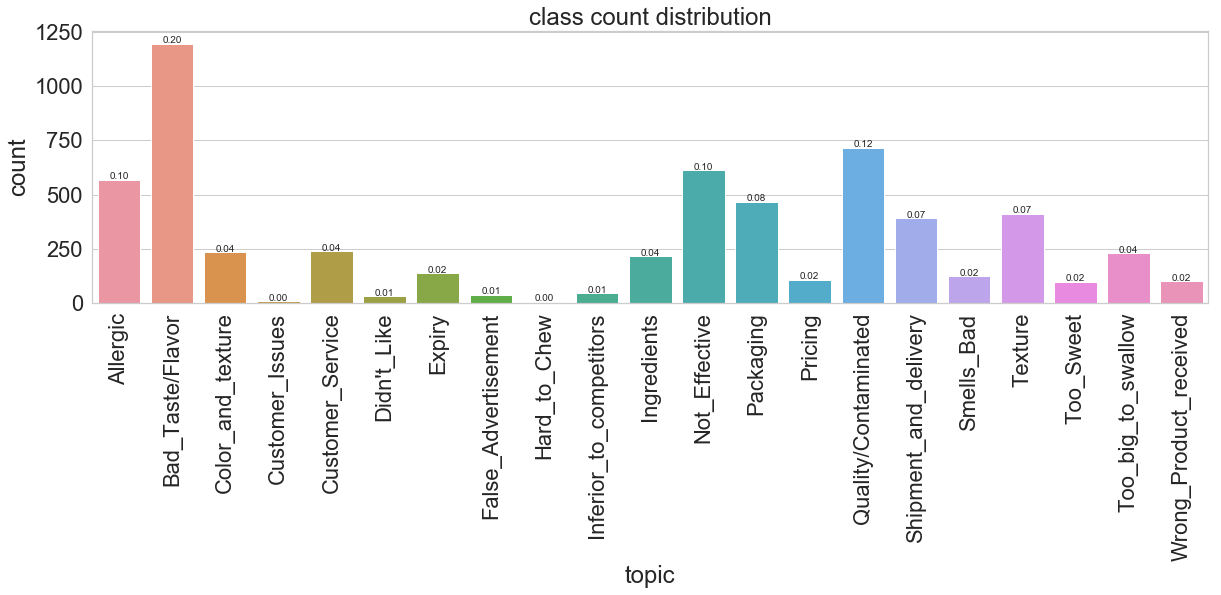

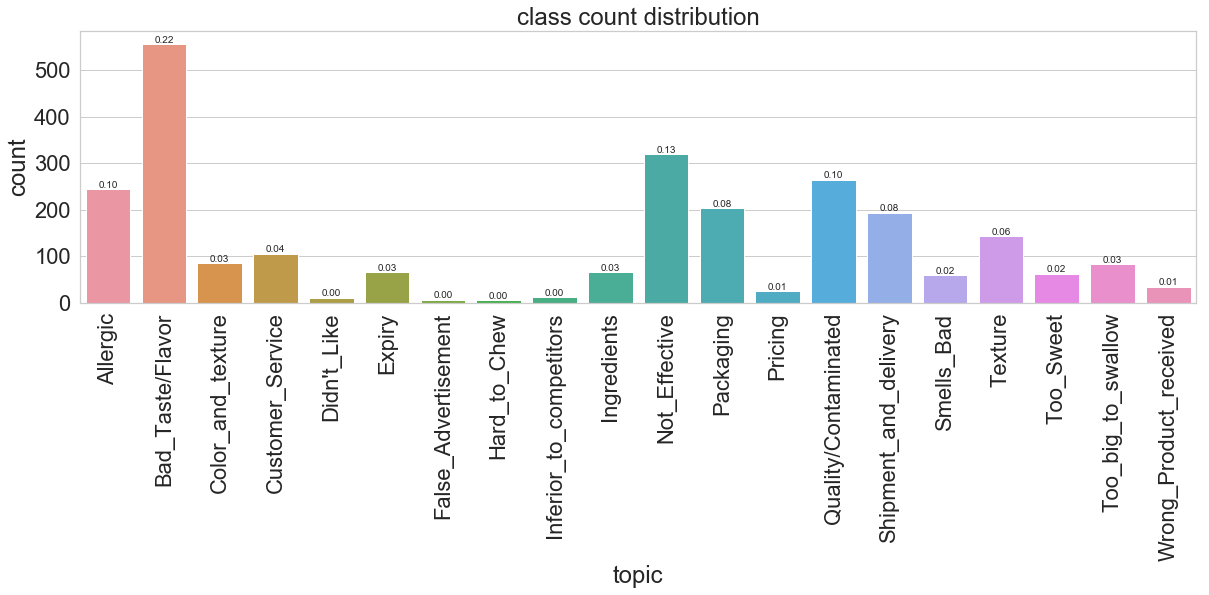

In [224]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(train['topic'].sort_values(), ax=ax)
ax.set_title("class count distribution")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
total = train.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(height/total), ha="center") 

fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(test4['topic'].sort_values(), ax=ax)
ax.set_title("class count distribution")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
total = test4.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(height/total), ha="center") 
    

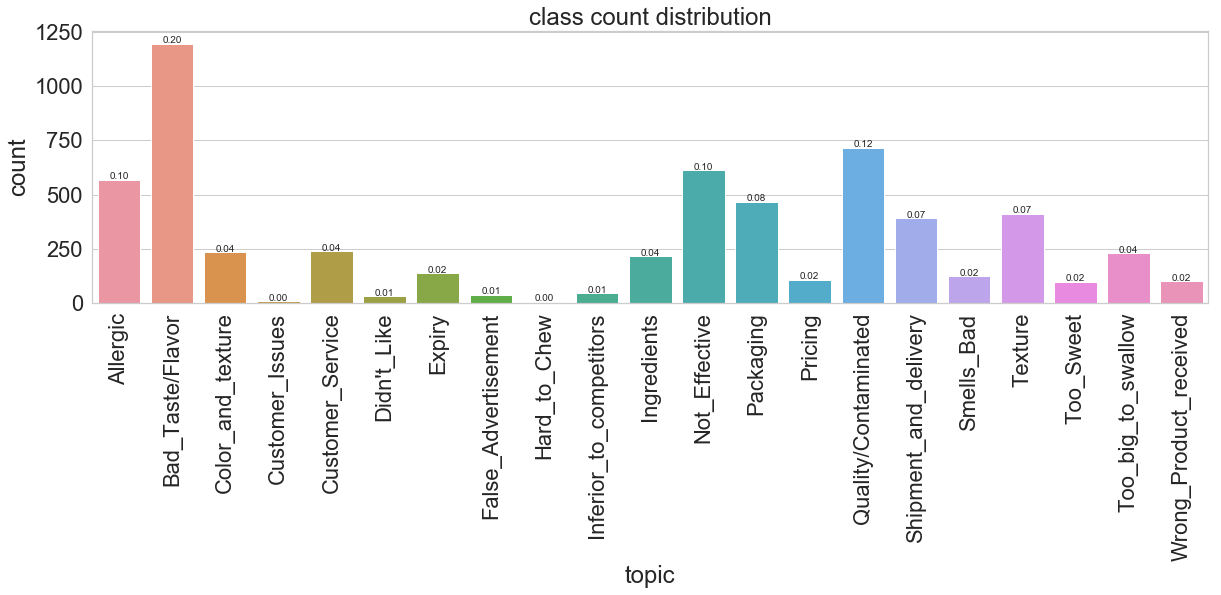

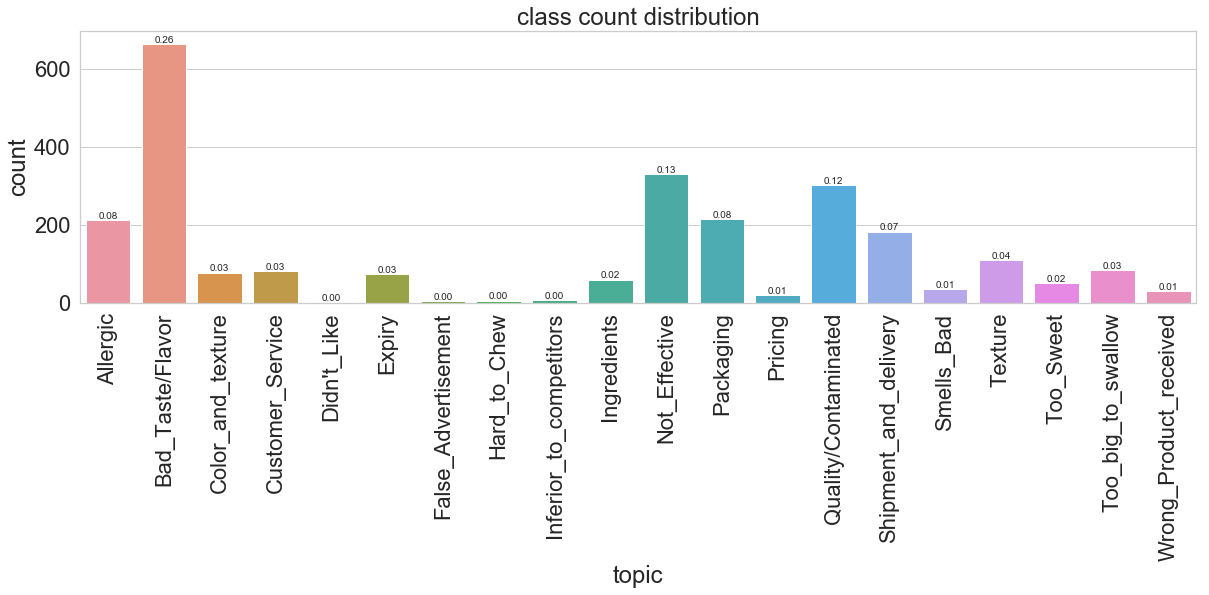

In [244]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(train['topic'].sort_values(), ax=ax)
ax.set_title("class count distribution")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
total = train.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(height/total), ha="center") 

fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(test4['topic'].sort_values(), ax=ax)
ax.set_title("class count distribution")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
total = test4.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(height/total), ha="center") 
    

In [211]:
sub

,Review Text,Review Title,topic
0,"Not terrible, but not good. Tastes burnt and a...",Not my cup o’ joe,Burnt/ Over -roast
1,"I am so disappointed, it has no flavor, doesn'...","I am so disappointed, it has no flavor",Bad Flavor/Taste
2,"I recently gave up my daily 6 cups of coffee, ...",Flavor was dissapointing,Bitter
3,Meh. I've adored Peruvian coffee for 20 years....,Smooth but majorly bland. Won't repurchase.,NaN
4,Meh. I've adored Peruvian coffee for 20 years....,Smooth but majorly bland. Won't repurchase.,NaN


In [142]:
cl_map

{'Allergic': 0,
 'Bad_Taste/Flavor': 1,
 'Color_and_texture': 2,
 'Customer_Issues': 3,
 'Customer_Service': 4,
 "Didn't_Like": 5,
 'Expiry': 6,
 'False_Advertisement': 7,
 'Hard_to_Chew': 8,
 'Inferior_to_competitors': 9,
 'Ingredients': 10,
 'Not_Effective': 11,
 'Packaging': 12,
 'Pricing': 13,
 'Quality/Contaminated': 14,
 'Shipment_and_delivery': 15,
 'Smells_Bad': 16,
 'Texture': 17,
 'Too_Sweet': 18,
 'Too_big_to_swallow': 19,
 'Wrong_Product_received': 20}

,index,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received,overall
0,0,0.918483,0.894787,0.968720,0.999052,0.901422,0.988626,0.993365,0.994313,0.999052,0.981043,0.963033,0.891943,0.941232,0.979147,0.914692,0.927014,0.960190,0.952607,0.977251,0.981991,0.969668,0.957030
1,1,0.919431,0.904265,0.968720,0.998104,0.916588,0.988626,0.992417,0.994313,0.997156,0.983886,0.960190,0.894787,0.938389,0.985782,0.913744,0.941232,0.963033,0.959242,0.973460,0.976303,0.975355,0.959287
2,2,0.924171,0.903318,0.973460,0.999052,0.921327,0.987678,0.996209,0.992417,0.999052,0.979147,0.965877,0.911848,0.948815,0.984834,0.909005,0.938389,0.964929,0.951659,0.987678,0.976303,0.981991,0.961769
3,3,0.915640,0.890995,0.974408,1.000000,0.929858,0.991469,0.993365,0.992417,0.998104,0.983886,0.969668,0.908057,0.934597,0.981991,0.908057,0.932701,0.974408,0.951659,0.984834,0.971564,0.976303,0.960190
4,4,0.909953,0.896682,0.980095,0.999052,0.909953,0.991469,0.994313,0.991469,0.998104,0.982938,0.970616,0.910900,0.939336,0.985782,0.906161,0.933649,0.970616,0.954502,0.981043,0.982938,0.975355,0.960235
5,5,0.918483,0.907109,0.971564,0.998104,0.931754,0.992417,0.994313,0.992417,0.998104,0.987678,0.967773,0.900474,0.925118,0.983886,0.903318,0.927962,0.968720,0.952607,0.985782,0.968720,0.980095,0.959828
6,6,0.899526,0.894787,0.971564,0.999052,0.914692,0.988626,0.993365,0.993365,0.998104,0.982938,0.960190,0.901422,0.938389,0.984834,0.912796,0.935545,0.969668,0.958294,0.982938,0.981991,0.979147,0.959106
7,7,0.929858,0.907109,0.966825,1.000000,0.923223,0.991469,0.990521,0.995261,0.998104,0.982938,0.971564,0.893839,0.942180,0.981991,0.910900,0.937441,0.971564,0.961137,0.982938,0.975355,0.974408,0.961363
8,8,0.925118,0.900474,0.981043,0.999052,0.909005,0.991469,0.992417,0.993365,0.998104,0.984834,0.965877,0.902370,0.935545,0.981991,0.909005,0.929858,0.968720,0.958294,0.985782,0.976303,0.973460,0.960099
9,9,0.914692,0.895735,0.972512,0.999052,0.920379,0.993365,0.994313,0.994313,0.999052,0.980095,0.967773,0.906161,0.946919,0.980095,0.902370,0.937441,0.971564,0.960190,0.982938,0.976303,0.983886,0.960912


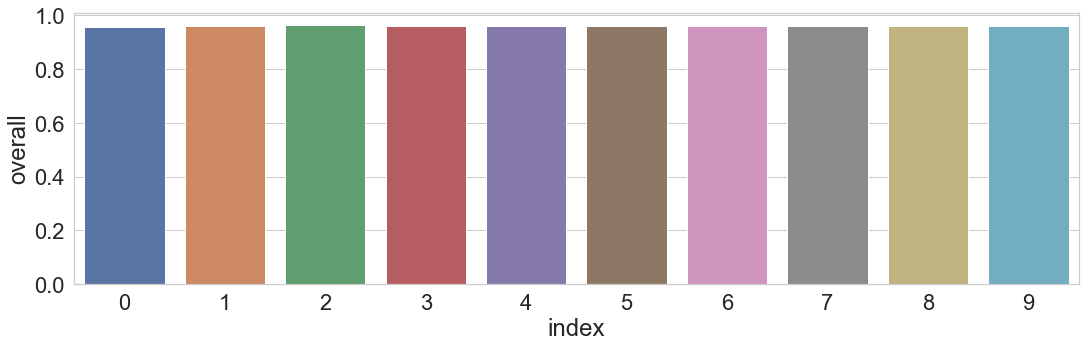

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(tfidf_text_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
acc_table['overall'] = acc_table.apply(lambda x: np.mean(x), axis=1)
acc_table = acc_table.reset_index()
fig, ax = plt.subplots(1,1,figsize=(18, 5))
sns.barplot(x='index',y='overall',data=acc_table, ax=ax)
acc_table

,index,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received,overall
0,0,0.905213,0.902370,0.970616,0.998104,0.901422,0.983886,0.997156,0.995261,0.997156,0.978199,0.966825,0.896682,0.934597,0.987678,0.909005,0.927014,0.968720,0.963981,0.978199,0.971564,0.974408,0.957527
1,1,0.921327,0.898578,0.981043,0.999052,0.920379,0.991469,0.993365,0.995261,0.998104,0.981991,0.966825,0.908057,0.946919,0.983886,0.909005,0.943128,0.965877,0.953555,0.981991,0.974408,0.977251,0.961499
2,2,0.919431,0.888152,0.978199,0.999052,0.916588,0.992417,0.995261,0.996209,0.998104,0.983886,0.965877,0.914692,0.947867,0.983886,0.900474,0.937441,0.964929,0.955450,0.981991,0.976303,0.980095,0.960776
3,3,0.918483,0.895735,0.976303,0.999052,0.927962,0.988626,0.993365,0.993365,0.998104,0.986730,0.963981,0.891943,0.936493,0.982938,0.911848,0.934597,0.965877,0.961137,0.981043,0.984834,0.972512,0.960235
4,4,0.925118,0.890047,0.977251,0.998104,0.909005,0.991469,0.992417,0.993365,0.998104,0.987678,0.964929,0.908057,0.934597,0.984834,0.912796,0.935545,0.969668,0.959242,0.976303,0.980095,0.975355,0.960190
5,5,0.923223,0.902370,0.978199,0.999052,0.912796,0.990521,0.989573,0.993365,0.998104,0.983886,0.964929,0.904265,0.937441,0.984834,0.927962,0.931754,0.965877,0.949763,0.976303,0.974408,0.984834,0.960641
6,6,0.910900,0.909005,0.969668,0.999052,0.901422,0.989573,0.993365,0.994313,0.998104,0.984834,0.967773,0.888152,0.943128,0.983886,0.909005,0.945972,0.965877,0.955450,0.980095,0.974408,0.981043,0.959287
7,7,0.910900,0.895735,0.980095,0.999052,0.913744,0.993365,0.994313,0.995261,0.999052,0.980095,0.967773,0.906161,0.949763,0.988626,0.906161,0.935545,0.967773,0.949763,0.977251,0.973460,0.977251,0.960054
8,8,0.917536,0.890995,0.978199,0.999052,0.921327,0.988626,0.994313,0.994313,0.998104,0.981991,0.968720,0.903318,0.931754,0.985782,0.922275,0.932701,0.969668,0.960190,0.982938,0.979147,0.981991,0.961092
9,9,0.911848,0.902370,0.973460,0.999052,0.924171,0.991469,0.995261,0.996209,0.998104,0.985782,0.964929,0.889100,0.952607,0.982938,0.902370,0.928910,0.969668,0.959242,0.981991,0.968720,0.978199,0.959828


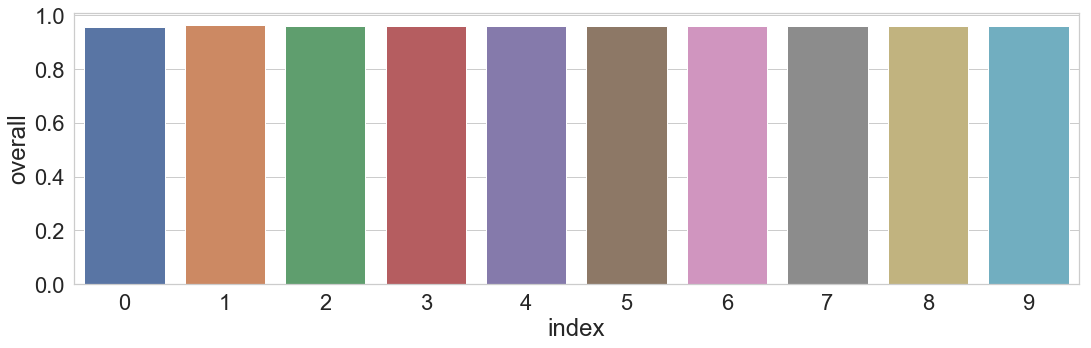

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(tfidf_title_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
acc_table['overall'] = acc_table.apply(lambda x: np.mean(x), axis=1)
acc_table = acc_table.reset_index()
fig, ax = plt.subplots(1,1,figsize=(18, 5))
sns.barplot(x='index',y='overall',data=acc_table, ax=ax)

acc_table

## following block can't be run on this dataset, because i manipulated it to multilabel

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split    

for i, data in enumerate(cvect_text_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

print("="*30)
for i, data in enumerate(cvect_title_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
    print('cvect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

    
for i, data in enumerate(tfidf_text_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

print("="*30)
for i, data in enumerate(tfidf_title_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
    print('cvect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))


tfidf 0          acc: 0.3557
tfidf 1          acc: 0.3342
tfidf 2          acc: 0.3315
tfidf 3          acc: 0.3235
tfidf 4          acc: 0.3094
tfidf 5          acc: 0.3067
tfidf 6          acc: 0.3128
tfidf 7          acc: 0.2993
tfidf 8          acc: 0.3181
tfidf 9          acc: 0.3154
count-vect 0          acc: 0.3081
count-vect 1          acc: 0.3295
count-vect 2          acc: 0.3497
count-vect 3          acc: 0.3879
count-vect 4          acc: 0.4013
count-vect 5          acc: 0.4188
count-vect 6          acc: 0.4195
count-vect 7          acc: 0.4383
count-vect 8          acc: 0.4416
count-vect 9          acc: 0.4436


In [41]:
pred = clf.predict(count_vect_text[-1])
pred.shape

(8512,)

In [45]:
pred = pd.DataFrame(data=pred[-test.shape[0]:], columns=['target'])
sub1 = pd.concat([test, pred], axis=1)
sub1['topic'] = sub1['target'].apply(lambda x: cl_map_inv[x])

sub1.drop('target', axis=1, inplace=True)
sub1.columns = sub.columns
sub1.to_csv('submission/sub3_countvect_text_15.csv', index=None)
sub1.head()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
1,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients


In [23]:
train2.shape, test2.shape

((4210, 3), (1773, 3))

In [24]:
df1['topic1'] = df1['topic']
df1['topic'] = df1['topic1'].apply(lambda x: x.split(" ")[0])
train4 = df1[:train2.shape[0]]
test4  = df1[train2.shape[0]:]
train4.drop('topic1', axis=1, inplace=True)
test4.drop('topic1', axis=1, inplace=True)
train4.shape, test4.shape

((4210, 3), (1773, 3))

In [25]:
df3 = train4.append(test4, ignore_index=True)
df3.shape

(5983, 3)

In [30]:
cvect_text_store = []
for ngram in [1,2,3,5,8,10]:
    cvect = get_count_vectorizer(df3, 'title', ngram)
    print(cvect.shape)
    cvect_text_store.append(cvect)
    
tfidf_text_store = []
for ngram in [1,2,3,5,7,8,10]:
    tfidf = get_tfidf_feature(df3, 'text', ngram=ngram)
    print(tfidf.shape)
    tfidf_text_store.append(tfidf)
    
cvect_title_store = []
for ngram in [1,2,3,5,8,10]:
    cvect = get_count_vectorizer(df3, 'title', ngram)
    print(cvect.shape)
    cvect_title_store.append(cvect)
    
tfidf_title_store = []
for ngram in [1,2,3,5,7,8,10]:
    tfidf = get_tfidf_feature(df3, 'title', ngram=ngram)
    print(tfidf.shape)
    tfidf_title_store.append(tfidf)

(5983, 14131)
(5983, 2151)
(5983, 1259)
(5983, 702)
(5983, 439)
(5983, 336)
(5983, 3684)
(5983, 8192)
(5983, 8630)
(5983, 8750)
(5983, 8829)
(5983, 8864)
(5983, 8926)
(5983, 14131)
(5983, 2151)
(5983, 1259)
(5983, 702)
(5983, 439)
(5983, 336)
(5983, 849)
(5983, 1221)
(5983, 1259)
(5983, 1259)
(5983, 1259)
(5983, 1259)
(5983, 1259)


In [14]:
# tr_len = train.shape[0]
# ts_len = test.shape[0]
# # train.shape[0] + test.shape[0], df.shape[0]
# train1 = df.iloc[:tr_len]
# test1  = df.iloc[tr_len:]
# train1.shape, test1.shape

((5959, 3), (2553, 3))

In [27]:
train4['target'] = train4['topic'].astype('category').cat.codes
train4['target'] = train4['target'].astype('int')


In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split    

for i, data in enumerate(tfidf_text_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
#     print("tfidf "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

    
print("="*30)
for i, data in enumerate(cvect_text_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
#     print("count-vect "+str(i), clf.score(X_test, Y_test))
    print('count-vect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

    
print("="*30)
    
for i, data in enumerate(tfidf_title_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
#     print("tfidf "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

    
print("="*30)
for i, data in enumerate(cvect_title_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf = MultinomialNB().fit(X_train, Y_train)
#     print("count-vect "+str(i), clf.score(X_test, Y_test))
    print('count-vect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))


tfidf 0          acc: 0.4606
tfidf 1          acc: 0.4653
tfidf 2          acc: 0.4653
tfidf 3          acc: 0.4748
tfidf 4          acc: 0.4444
tfidf 5          acc: 0.4663
tfidf 6          acc: 0.4729
tfidf 7          acc: 0.4444
tfidf 8          acc: 0.4691
tfidf 9          acc: 0.4473
tfidf 10         acc: 0.4416
tfidf 11         acc: 0.4634
tfidf 12         acc: 0.4682
tfidf 13         acc: 0.4302
count-vect 0          acc: 0.4511
count-vect 1          acc: 0.4720
count-vect 2          acc: 0.4872
count-vect 3          acc: 0.4976
count-vect 4          acc: 0.4653
count-vect 5          acc: 0.4796
count-vect 6          acc: 0.4710
count-vect 7          acc: 0.4663
count-vect 8          acc: 0.4919
count-vect 9          acc: 0.4995
count-vect 10         acc: 0.4729
count-vect 11         acc: 0.4976


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    
import warnings
warnings.filterwarnings("ignore")

clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split    

for i, data in enumerate(tfidf_text_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf.fit(X_train, Y_train)
#     print("tfidf "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

    
print("="*30)
for i, data in enumerate(cvect_text_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf.fit(X_train, Y_train)
#     print("count-vect "+str(i), clf.score(X_test, Y_test))
    print('count-vect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

    
print("="*30)
    
for i, data in enumerate(tfidf_title_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf.fit(X_train, Y_train)
#     print("tfidf "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

    
print("="*30)
for i, data in enumerate(cvect_title_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf.fit(X_train, Y_train)
#     print("count-vect "+str(i), clf.score(X_test, Y_test))
    print('count-vect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))


tfidf 0          acc: 0.6192
tfidf 1          acc: 0.6277
tfidf 2          acc: 0.6049
tfidf 3          acc: 0.6239
tfidf 4          acc: 0.6287
tfidf 5          acc: 0.6144
tfidf 6          acc: 0.6106
tfidf 7          acc: 0.4539
tfidf 8          acc: 0.4577
tfidf 9          acc: 0.4881
tfidf 10         acc: 0.4701
tfidf 11         acc: 0.4672
tfidf 12         acc: 0.4663
tfidf 13         acc: 0.4349
count-vect 0          acc: 0.4862
count-vect 1          acc: 0.4558
count-vect 2          acc: 0.4615
count-vect 3          acc: 0.4520
count-vect 4          acc: 0.4179
count-vect 5          acc: 0.4416
count-vect 6          acc: 0.4758
count-vect 7          acc: 0.4587
count-vect 8          acc: 0.4501
count-vect 9          acc: 0.4501
count-vect 10         acc: 0.4435
count-vect 11         acc: 0.4084


In [60]:
# from sklearn.preprocessing import StandardScaler
# stdc = StandardScaler()

# logistic_reg = LogisticRegression(penalty='l2', dual=False, solver='lbfgs',
#     C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
#     random_state=1234, max_iter=100, multi_class='multinomial', verbose=0, n_jobs=4)

# for i, data in enumerate(tfidf_text_store):
#     train_ = data[:train.shape[0]]
#     X_train, X_test, Y_train, Y_test = train_test_split(
#         train_, train['target'], 
#         stratify=train['target'], 
#         test_size=0.25
#     )
# #     X_train = X_train.todense()
# #     X_test  = X_test.todense()
# #     stdc.fit(X_train)
#     clf = logistic_reg.fit(X_train, Y_train)
# #     print("log-reg "+str(i), clf.score(X_test, Y_test))
#     print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))


tfidf 0          acc: 0.4557
tfidf 1          acc: 0.4584
tfidf 2          acc: 0.4376
tfidf 3          acc: 0.4362
tfidf 4          acc: 0.4430
tfidf 5          acc: 0.4544
tfidf 6          acc: 0.4396
tfidf 7          acc: 0.4349
tfidf 8          acc: 0.4248
tfidf 9          acc: 0.4450


In [61]:
# logistic_reg = LogisticRegression(penalty='l2', dual=False, 
#     C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
#     random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

# for i, data in enumerate(tfidf_text_store):
#     train_ = data[:train.shape[0]]
#     X_train, X_test, Y_train, Y_test = train_test_split(
#         train_, train['target'], 
#         stratify=train['target'], 
#         test_size=0.25
#     )
#     clf = logistic_reg.fit(X_train, Y_train)
# #     print("log-reg "+str(i), clf.score(X_test, Y_test))
#     print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))


tfidf 0          acc: 0.4859
tfidf 1          acc: 0.4893
tfidf 2          acc: 0.4550
tfidf 3          acc: 0.4779
tfidf 4          acc: 0.4624
tfidf 5          acc: 0.4839
tfidf 6          acc: 0.4758
tfidf 7          acc: 0.4812
tfidf 8          acc: 0.4530
tfidf 9          acc: 0.4544


In [37]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split    
import warnings
warnings.filterwarnings("ignore")

clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                        max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                        random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                        early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                        class_weight='balanced', warm_start=False, average=False, n_iter=1000)

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split    

for i, data in enumerate(tfidf_text_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf.fit(X_train, Y_train)
#     print("tfidf "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

    
print("="*30)
for i, data in enumerate(cvect_text_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf.fit(X_train, Y_train)
#     print("count-vect "+str(i), clf.score(X_test, Y_test))
    print('count-vect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

    
print("="*30)
    
for i, data in enumerate(tfidf_title_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf.fit(X_train, Y_train)
#     print("tfidf "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

    
print("="*30)
for i, data in enumerate(cvect_title_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf.fit(X_train, Y_train)
#     print("count-vect "+str(i), clf.score(X_test, Y_test))
    print('count-vect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))


tfidf 0          acc: 0.6676
tfidf 1          acc: 0.6686
tfidf 2          acc: 0.6676
tfidf 3          acc: 0.6496
tfidf 4          acc: 0.6705
tfidf 5          acc: 0.6610
tfidf 6          acc: 0.6515
tfidf 7          acc: 0.4672
tfidf 8          acc: 0.4568
tfidf 9          acc: 0.4644
tfidf 10         acc: 0.4558
tfidf 11         acc: 0.4539
tfidf 12         acc: 0.4520
tfidf 13         acc: 0.4701
count-vect 0          acc: 0.4701
count-vect 1          acc: 0.4359
count-vect 2          acc: 0.4767
count-vect 3          acc: 0.4558
count-vect 4          acc: 0.3998
count-vect 5          acc: 0.4359
count-vect 6          acc: 0.4663
count-vect 7          acc: 0.4644
count-vect 8          acc: 0.4511
count-vect 9          acc: 0.4558
count-vect 10         acc: 0.4330
count-vect 11         acc: 0.3837


In [78]:
# from sklearn.linear_model import SGDClassifier

# sgd_clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
#                         max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
#                         random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
#                         early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
#                         class_weight='balanced', warm_start=False, average=False, n_iter=1000)
# sgd_clf.fit(X_train, Y_train)
# sgd_clf.score(X_test, Y_test)

0.49261744966442955

In [79]:
pred = sgd_clf.predict(X_test)
pred.shape

(1490,)

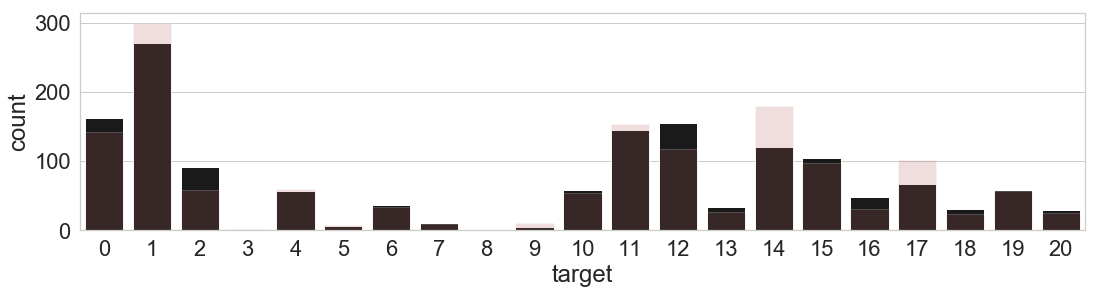

In [95]:
fig, ax = plt.subplots(1,1, figsize=(18, 4))
sns.countplot(pred, color='k', ax=ax)
sns.countplot(Y_test, color='r', ax=ax, alpha=0.2)

In [97]:
for i, data in enumerate(tfidf_text_store):
    train_ = data[:train.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train['target'], 
        stratify=train['target'], 
        test_size=0.25
    )
    
    sgd_clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                        max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                        random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                        early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                        class_weight='balanced', warm_start=False, average=False, n_iter=1000)
    sgd_clf.fit(X_train, Y_train)
#     sgd_clf.score(X_test, Y_test)

#     clf = logistic_reg.fit(X_train, Y_train)
#     print("log-reg "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), sgd_clf.score(X_test, Y_test)))


tfidf 0          acc: 0.4866
tfidf 1          acc: 0.4960
tfidf 2          acc: 0.4826
tfidf 3          acc: 0.5148
tfidf 4          acc: 0.5034
tfidf 5          acc: 0.4913
tfidf 6          acc: 0.5020
tfidf 7          acc: 0.4960
tfidf 8          acc: 0.4886
tfidf 9          acc: 0.5087


In [99]:
train_ = tfidf_text_store[4][:train.shape[0]]
test_  = tfidf_text_store[4][train.shape[0]:]

sgd_clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                    max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                    random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                    early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                    class_weight='balanced', warm_start=False, average=False, n_iter=1000)
sgd_clf.fit(train_, train['target'])
pred = sgd_clf.predict(test_)
pred.shape, test.shape

((2553,), (2553, 2))

In [100]:
pred = pd.DataFrame(data=pred[-test.shape[0]:], columns=['target'])
sub1 = pd.concat([test, pred], axis=1)
sub1['topic'] = sub1['target'].apply(lambda x: cl_map_inv[x])

sub1.drop('target', axis=1, inplace=True)
sub1.columns = sub.columns
sub1.to_csv('submission/sub4_tfidf4_sgd.csv', index=None)
sub1.head()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
1,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients


In [102]:
sub1.drop_duplicates()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
5,I used to be loyal customer to this brand. I h...,SMELL HORRIBLE!,Quality/Contaminated
9,I haven’t received it yet.,Shipping,Shipment and delivery
10,"I bought these for my girlfriend, who I couldn...",These suppliments don't work - No suppliment s...,Not Effective
11,"The almonds were sealed, but not dusted separa...","Heated damaged contents...Not dusted almonds, ...",Wrong Product received
12,I really wanted to give these a try and notice...,Vitex,Allergic
14,"I ordered Cherry Vanilla, got BlackBerry. Cus...",Wrong description !!! Or wrong product?,Wrong Product received
16,Buyer beware: these vitamins are not technical...,"These are not vegan, but ""X Brand""'s Customer ...",Ingredients


In [207]:
train_ = count_vect[-2][:train.shape[0]]
X_train, X_test, Y_train, Y_test = train_test_split(
    train_, train['target'], 
    stratify=train['target'], 
    test_size=0.25
)
logistic_reg = LogisticRegression(penalty='l2', dual=False, 
    C=0.2, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

clf = logistic_reg.fit(X_train, Y_train)
print("log-reg ", clf.score(X_test, Y_test))

log-reg  0.4006711409395973


In [208]:
from sklearn.feature_selection import SelectFromModel

# model = LogisticRegression(solver='sag')
sfm = SelectFromModel(logistic_reg, threshold=0.25)

In [209]:
train_sparse_matrix = sfm.fit_transform(train_, target)
    

In [210]:
train_sparse_matrix.shape, train_.shape

((5959, 1486), (5959, 1650))

In [211]:
train_sparse_matrix = train_sparse_matrix.todense()
train_sparse_matrix = pd.DataFrame(train_sparse_matrix)
train_sparse_matrix.columns = ['col'+str(i) for i in range(train_sparse_matrix.shape[1])]

In [232]:
train_ = df[:train.shape[0]]
test_  = df[train.shape[0]:]
train_.shape, test_.shape

((5959, 3), (2553, 3))

In [244]:
kuch_title1 = tfidf_feature(train, test, 'title', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=2, stopwords='english', 
                  n_component=75, decom_flag=True, which_method='svd', 
                  max_features=None, feat_col_name='svd_title1')

kuch_title2 = tfidf_feature(train, test, 'title', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=75, decom_flag=True, which_method='svd', 
                  max_features=None, feat_col_name='svd_title2')

kuch_text11 = tfidf_feature(train, test, 'text', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=2, stopwords='english', 
                  n_component=100, decom_flag=True, which_method='svd', 
                  max_features=None, feat_col_name='svd_text11')

kuch_text21 = tfidf_feature(train, test, 'text', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=100, decom_flag=True, which_method='svd', 
                  max_features=None, feat_col_name='svd_text21')


kuch_text12 = tfidf_feature(train, test, 'text', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=2, stopwords='english', 
                  n_component=50, decom_flag=True, which_method='nmf', 
                  max_features=None, feat_col_name='svd_text12')

kuch_text22 = tfidf_feature(train, test, 'text', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=50, decom_flag=True, which_method='nmf', 
                  max_features=None, feat_col_name='svd_text22')


===============  done  ===============
===============  done  ===============
===============  done  ===============
===============  done  ===============
===============  done  ===============
===============  done  ===============


In [245]:
gc.collect()
train_all = pd.concat([kuch_title1[0], kuch_title2[0], kuch_text11[0],
                       kuch_text12[0], kuch_text21[0], kuch_text22[0]], axis=1)
test_all  = pd.concat([kuch_title1[1], kuch_title2[1], kuch_text11[1],
                       kuch_text12[1], kuch_text21[1], kuch_text22[1]], axis=1)

train_all.shape, test_all.shape

((5959, 450), (2553, 450))

In [246]:
_, f, _ = run_cv_lgb(train_all, train['target'], leaves=70)

using leaves:  70
(4463,) (1496,)
Fold 0
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.147056	valid_1's auc: 0.236048
  auc =  0.4391711229946524
0.7179144385026738
(4465,) (1494,)
Fold 1
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.171365	valid_1's auc: 0.218049
  auc =  0.4243641231593039
0.715528781793842
(4470,) (1489,)
Fold 2
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.175862	valid_1's auc: 0.247368
  auc =  0.40899932840832776
0.6991269308260577
(4479,) (1480,)
Fold 3
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.169342	valid_1's auc: 0.221444
  auc =  0.4195945945945946
0.6925675675675675


In [249]:
f.sort_values('imp', ascending=False)[:100]

,feature,imp
300,svd_title1_0,5.5
301,svd_title1_1,3.25
4,svd_text11_12,2.5
133,svd_text12_39,2.5
136,svd_text12_41,2.25
141,svd_text12_46,2.25
121,svd_text12_28,2
132,svd_text12_38,2
345,svd_title1_5,1.75
312,svd_title1_2,1.75


In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, NMF, PCA

def get_decomposition(train, test=None, n_component=2, col_name=None, which_method='svd',):
    
    complete_df = train
#     if col_name is None:
#         col_name = train.columns

#     if test is None:
#         complete_df = train[col_name]
#     else:
#         complete_df = pd.concat([train[col_name], test[col_name]], axis=0)

    if which_method is 'svd':
        method = TruncatedSVD(n_components=n_component, random_state=1234)
    elif which_method is 'nmf':
        method = NMF(n_components=n_components, random_state=1234, alpha=alpha, l1_ratio=l1_ratio)
    elif which_method is 'pca':
        method = PCA(n_components=n_components, random_state=1234, whitten=False)
    else:
        raise Exception("Please make sure which_method is one of [svd, nmf, [pca]]")

    complete_method = method.fit_transform(complete_df)

    complete_method = pd.DataFrame(data=complete_method)
    complete_method.columns = [which_method+'_'+str(i) for i in range(n_component)]

    train_method = complete_method.iloc[:train.shape[0]]
    if test is None:
        return train_method
    else:
        test_method = complete_method.iloc[train.shape[0]:].reset_index(drop=True)
        return train_method, test_method
        



In [54]:
text1  = tfidf_text_store[0]
title1 = tfidf_text_store[7]
text2  = tfidf_text_store[1]
title2 = tfidf_text_store[8]

m = []
for data in [text1, text2]:
    m.append(get_decomposition(data, n_component=150))

for data in [title1, title2]:
    m.append(get_decomposition(data, n_component=50))

In [56]:
trains = []
tests  = []
for data in m:
    trains.append(data[:train4.shape[0]])
    tests.append(data[train4.shape[0]:])


In [57]:
trains_stdc = []
tests_stdc  = []
for tr,ts in zip(trains, tests):
    stdc = StandardScaler()
    stdc.fit(tr)
    trains_stdc.append(stdc.transform(tr))
    tests_stdc.append(stdc.transform(ts))


In [59]:
del trains, tests
gc.collect()

3530

In [65]:
trains_stdc[0].shape, trains_stdc[1].shape

array([[-2.14557191e+00, -7.18295804e-02,  1.08993787e-01, ...,
         8.64398543e-03,  5.03533299e-03,  3.23164611e-04],
       [ 6.81095860e-01, -3.54235141e-01,  8.17948132e-02, ...,
         8.54704671e-01, -8.90646802e-01, -1.01515196e+00],
       [ 8.11989990e-01, -7.45253166e-01, -6.83591769e-01, ...,
         1.11454906e-01, -2.42350872e-01, -2.14862848e-01],
       ...,
       [-3.62108271e-01, -5.43807122e-01, -4.22554519e-01, ...,
        -9.82227654e-01,  1.77364025e-01, -1.40559453e+00],
       [-2.13074200e+00, -7.04347658e-02,  1.03356272e-01, ...,
        -9.04107437e-02, -9.15228612e-02, -1.07150071e-02],
       [ 9.30837244e-01, -8.61447058e-01, -9.33795649e-01, ...,
        -2.17819940e+00,  2.27516892e+00,  5.52624607e-02]])

In [71]:
train_all = np.concatenate([trains_stdc[0], trains_stdc[1], trains_stdc[2], trains_stdc[3]], axis=1)
test_all  = np.concatenate([tests_stdc[0], tests_stdc[1], tests_stdc[2], tests_stdc[3]], axis=1)

train_all = pd.DataFrame(data=train_all)
test_all  = pd.DataFrame(data=test_all)
train_all.columns = ["col_"+str(i) for i in range(train_all.shape[1])]
test_all.columns  = ["col_"+str(i) for i in range(test_all.shape[1])]

train_all.head().append(test_all.head())

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63,col_64,col_65,col_66,col_67,col_68,col_69,col_70,col_71,col_72,col_73,col_74,col_75,col_76,col_77,col_78,col_79,col_80,col_81,col_82,col_83,col_84,col_85,col_86,col_87,col_88,col_89,col_90,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,...,col_300,col_301,col_302,col_303,col_304,col_305,col_306,col_307,col_308,col_309,col_310,col_311,col_312,col_313,col_314,col_315,col_316,col_317,col_318,col_319,col_320,col_321,col_322,col_323,col_324,col_325,col_326,col_327,col_328,col_329,col_330,col_331,col_332,col_333,col_334,col_335,col_336,col_337,col_338,col_339,col_340,col_341,col_342,col_343,col_344,col_345,col_346,col_347,col_348,col_349,col_350,col_351,col_352,col_353,col_354,col_355,col_356,col_357,col_358,col_359,col_360,col_361,col_362,col_363,col_364,col_365,col_366,col_367,col_368,col_369,col_370,col_371,col_372,col_373,col_374,col_375,col_376,col_377,col_378,col_379,col_380,col_381,col_382,col_383,col_384,col_385,col_386,col_387,col_388,col_389,col_390,col_391,col_392,col_393,col_394,col_395,col_396,col_397,col_398,col_399
0,-2.145572,-0.071830,0.108994,0.133072,-0.045485,0.010020,0.024649,0.033390,0.046023,-0.060217,0.044903,0.016897,-0.012246,-0.036958,-0.008444,-0.014244,0.015731,-0.037104,-0.024337,0.003835,-0.003019,-0.004690,0.002676,-0.012050,0.013788,-0.001209,-0.003654,-0.012188,-0.027840,-0.000018,-0.004801,-0.039320,-0.026941,0.027345,0.002159,0.018131,0.022749,0.014739,-0.034763,-0.006992,-0.021986,0.047495,0.009240,0.003136,-0.013780,0.017966,-0.020782,-0.011549,0.017188,-0.029849,-0.037677,-0.032560,0.008617,-0.017799,0.019321,-0.005805,-0.030255,-0.034215,0.014046,-0.026541,-0.008477,-0.002550,-0.004280,0.011135,0.009794,-0.016518,0.018398,0.025983,-0.001340,-0.011162,-0.018557,-0.011173,-0.010312,-0.044784,-0.005634,-0.022110,0.003690,-0.017010,0.038566,0.001762,-0.018432,0.011911,-0.010026,-0.023824,-0.011948,-0.002959,-0.019853,0.030322,-0.006256,0.008733,0.018635,-0.017493,0.010698,-0.013944,0.044054,-0.020106,-0.018154,-0.019186,-0.001048,-0.003560,...,-0.584179,-0.049143,-0.209256,-0.115446,-0.121125,0.125046,-0.103269,-0.045988,0.029172,-0.158369,0.006951,0.058520,-0.173399,0.080877,-0.128017,-0.073799,-0.080607,-0.109476,-0.052490,-0.067811,-0.086177,-0.004147,-0.054414,-0.224362,-0.182044,0.148842,0.004261,-0.066710,-0.002812,0.037190,-0.154575,-0.146608,-0.207302,0.458096,0.029740,-0.357154,0.245036,-0.196056,-0.708552,-0.807378,-0.143058,0.094352,0.048568,0.144550,0.207792,-0.662964,0.515589,0.478697,0.000850,0.557659,-0.292738,-0.215190,-0.416577,0.062014,-0.222804,0.152816,-0.070381,-0.121628,-0.155955,-0.018429,-0.002174,-0.102454,0.003564,-0.194313,-0.081144,-0.122834,-0.058300,-0.171025,-0.030588,0.010775,-0.078338,0.071992,-0.007356,-0.019878,-0.077645,-0.015607,-0.442459,0.143324,-0.151879,-0.197645,0.090039,-0.253331,0.040282,-0.326913,0.081891,0.228792,-0.374701,-0.271647,-0.631307,-1.242450,0.260013,-0.015212,-0.954105,-0.739877,1.577109,-0.823567,-0.801247,0.288253,-0.170311,-0.461736
1,0.681096,-0.354235,0.081795,-1.170147,-0.100426,0.143964,-0.653729,-2.705512,-0.325122,-0.136200,-0.950173,-1.328494,0.322415,2.678381,0.176353,0.105848,0.217343,0.817174,-1.299211,0.453570,-1.407357,-0.505070,-0.012236,0.226128,-1.156812,0.183562,-1.699926,0.337936,1.139529,0.885527,0.275238,0.407847,0.297080,0.559750,0.937748,-1.751050,0.756763,-0.153740,-0.153078,1.985044,-0.252931,-1.505980,-1.895544,-0.990230,-0.569539,0.201969,-0.518145,0.838176,-0.580958,-0.521700,0.115198,0.880715,0.949159,-1.035163,0.455742,0.017491,0.231612,-0.781349,0.879446,-1.03216

In [73]:
target = train4['target']

In [275]:
# run_cv_xgb(train_all, target, depth=4)

In [72]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [270]:
# clf = xgb.XGBClassifier(max_depth=4, n_estimators=200, colsample_bytree=0.8, 
#                         subsample=0.8, nthread=10, learning_rate=0.1)
# clf.fit(train_all, target)
# predictions = clf.predict_proba(train_all)

# print ("logloss: %0.3f " % multiclass_logloss(target, predictions))

# score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
# print( "  auc = ", score )
# print(top_n_accuracy(Y_test, predictions, 3))
# print("="*60)
    

logloss: 0.522 


In [176]:
X_train, X_test, Y_train, Y_test = train_test_split(
    train_all, train4['target'], 
    stratify=train4['target'], 
    test_size=0.25
)
X_train.shape, Y_train.shape

((3157, 400), (3157,))

In [76]:
def top_n_accuracy(truths, preds, n):
    best_n = np.argsort(preds, axis=1)[:,-n:]
#     ts = np.argmax(truths, axis=1)
    ts = truths
    success = 0
    for t, p in zip(ts, best_n):
        if t in p:
            success += 1
    return float(success)/preds.shape[0]

In [77]:
clf = xgb.XGBClassifier(max_depth=4, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(X_train, Y_train)
predictions = clf.predict_proba(X_test)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))

score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)
    

logloss: 1.178 
  auc =  0.6818613485280152
0.8822412155745489


In [78]:
clf = xgb.XGBClassifier(max_depth=6, n_estimators=50, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(X_train, Y_train)
predictions = clf.predict_proba(X_test)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))

score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)
    

logloss: 1.240 
  auc =  0.6647673314339981
0.8660968660968661


In [79]:
clf = xgb.XGBClassifier(max_depth=5, n_estimators=300, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(X_train, Y_train)
predictions = clf.predict_proba(X_test)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))

score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)
    

logloss: 1.182 
  auc =  0.6894586894586895
0.886039886039886


In [80]:
# clf = xgb.XGBClassifier(max_depth=8, n_estimators=50, colsample_bytree=0.7, 
#                         subsample=0.7, nthread=10, learning_rate=0.05)
# clf.fit(X_train, Y_train)
# predictions = clf.predict_proba(X_test)

# print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))

# score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
# print( "  auc = ", score )
# print(top_n_accuracy(Y_test, predictions, 3))
# print("="*60)
    

logloss: 1.457 
  auc =  0.6486229819563153
0.8670465337132004


In [277]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
scl.fit(train_all)
train_all = scl.transform(train_all)


In [280]:
clf = xgb.XGBClassifier(max_depth=6, n_estimators=50, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(X_train, Y_train)
predictions = clf.predict_proba(X_test)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))

score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)
    

logloss: 1.881 
  auc =  0.4161073825503356
0.8422818791946308


In [282]:
# clf = MultinomialNB().fit(X_train, Y_train)
# predictions = clf.predictions
# print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))



# predictions = logistic_reg.pred

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=1234,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [177]:
logistic_reg = LogisticRegression(penalty='l2', dual=False, 
    C=0.01, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)
logistic_reg.fit(X_train, Y_train)

predictions = logistic_reg.predict_proba(X_test)
print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))
score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)


logloss: 1.761 
  auc =  0.6932573599240266
0.8774928774928775


In [178]:
predictions = logistic_reg.predict(test_all)
predictions.shape

(1773,)

In [179]:
test4.reset_index(drop=True)
test4['topic'] = predictions
final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
final1 = final1[['save_text','save_title','target']]
final1.columns = sub.columns
final1.head()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
1,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients


In [180]:
print(final1.shape)
final1.to_csv('submission/log1.csv',index=None)

(2553, 3)


In [82]:
from sklearn.svm import SVC
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(X_train, Y_train)
predictions = clf.predict_proba(X_test)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))
score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)


logloss: 1.187 
  auc =  0.6562203228869895
0.8774928774928775


In [83]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('../../ml-toolbox-testing/dataset/glove.6B/glove.6B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:25, 15839.14it/s]

Found 400000 word vectors.


In [84]:
df3.shape

(5983, 3)

In [193]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df3[:train4.shape[0]][['text','title']], train4['target'], 
    stratify=train4['target'], 
    test_size=0.25
)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3157, 2), (3157,), (1053, 2), (1053,))

In [95]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()#.decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(X_train['text'])]
xvalid_glove = [sent2vec(x) for x in tqdm(X_test['text'])]



100%|██████████| 1053/1053 [00:00<00:00, 2986.27it/s]


In [96]:
import nltk
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed
[nltk_data]     (_ssl.c:852)>


False

In [97]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)
xtrain_glove.shape, xvalid_glove.shape

((3157, 300), (1053, 300))

In [98]:
# Fitting a simple xgboost on glove features
# clf = xgb.XGBClassifier(nthread=10, silent=False)
clf = xgb.XGBClassifier(max_depth=5, n_estimators=50, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_glove, Y_train)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))
score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)


logloss: 1.615 
  auc =  0.5280151946818613
0.7711301044634378


In [99]:
# Fitting a simple xgboost on glove features
# clf = xgb.XGBClassifier(nthread=10, silent=False)
clf = xgb.XGBClassifier(max_depth=5, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_glove, Y_train)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))
score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)


logloss: 1.569 
  auc =  0.5489078822412156
0.7901234567901234


In [101]:
gc.collect()

5470

In [104]:
del xtrain_glove, xtrain_glove1, xvalid_glove
gc.collect()

1918

In [103]:
# # scale the data before any neural net:
# scl = StandardScaler()
# xtrain_glove = scl.fit_transform(xtrain_glove)
# xvalid_glove = scl.transform(xvalid_glove)


In [102]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text


Using TensorFlow backend.


In [316]:
try:
    del model
    gc.collect()
else:
    print("no model previously")
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(Y_train)
yvalid_enc = np_utils.to_categorical(Y_test)

# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(21))
model.add(Activation('softmax'))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 300)               1200      
_________________________________________________________________
dense_8 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 300)               1200      
_________________________________________________________________
dense_9 (Dense)              (None, 21)                6321      
__________

In [320]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(xtrain_glove, y=ytrain_enc, batch_size=64, 
          epochs=3, verbose=1, 
          validation_data=(xvalid_glove, yvalid_enc))


Train on 4469 samples, validate on 1490 samples
Epoch 1/3
4469/4469 [==============================] - 1s 283us/step - loss: 1.2083 - acc: 0.5963 - val_loss: 2.5464 - val_acc: 0.3530
Epoch 2/3
4469/4469 [==============================] - 0s 87us/step - loss: 1.1535 - acc: 0.5979 - val_loss: 2.5796 - val_acc: 0.3477
Epoch 3/3
4469/4469 [==============================] - 0s 88us/step - loss: 1.1485 - acc: 0.6124 - val_loss: 2.5863 - val_acc: 0.3409


In [130]:
batch_size = 64
epochs = 20

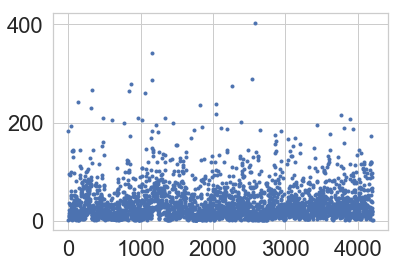

In [108]:
tr_len = X_train['text'].apply(lambda x: len(x.split(" ")))
plt.plot(tr_len, '.')

In [112]:
np.percentile(tr_len, 97)

128.3199999999997

In [143]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 128

token.fit_on_texts(list(X_train['text']) + list(X_test['text']))
xtrain_seq = token.texts_to_sequences(X_train['text'])
xvalid_seq = token.texts_to_sequences(X_test['text'])
xtest_seq  = token.texts_to_sequences(test4['text'])

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

ytrain_enc = np_utils.to_categorical(Y_train, num_classes=21)
yvalid_enc = np_utils.to_categorical(Y_test, num_classes=21)


100%|██████████| 8031/8031 [00:00<00:00, 443818.01it/s]


In [132]:
try:
    del model
    gc.collect()
except:
    print("no model previously")
    
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(21))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 300)          2409600   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 128, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
__________

In [133]:
xtrain_pad.shape, ytrain_enc.shape, xvalid_pad.shape, yvalid_enc.shape

((3157, 128), (3157, 21), (1053, 128), (1053, 21))

In [134]:
from keras.callbacks import EarlyStopping
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])



Train on 3157 samples, validate on 1053 samples
Epoch 1/20
3157/3157 [==============================] - 12s 4ms/step - loss: 2.7281 - acc: 0.1470 - val_loss: 2.5926 - val_acc: 0.2099
Epoch 2/20
3157/3157 [==============================] - 13s 4ms/step - loss: 2.5920 - acc: 0.1825 - val_loss: 2.4672 - val_acc: 0.2764
Epoch 3/20
3157/3157 [==============================] - 12s 4ms/step - loss: 2.4659 - acc: 0.2452 - val_loss: 2.2499 - val_acc: 0.3248
Epoch 4/20
3157/3157 [==============================] - 13s 4ms/step - loss: 2.3204 - acc: 0.2924 - val_loss: 2.1442 - val_acc: 0.3466
Epoch 5/20
3157/3157 [==============================] - 13s 4ms/step - loss: 2.2352 - acc: 0.3212 - val_loss: 2.0659 - val_acc: 0.3675
Epoch 6/20
3157/3157 [==============================] - 13s 4ms/step - loss: 2.1531 - acc: 0.3475 - val_loss: 2.0114 - val_acc: 0.3837
Epoch 7/20
3157/3157 [==============================] - 13s 4ms/step - loss: 2.0847 - acc: 0.3627 - val_loss: 1.9645 - val_acc: 0.4074
Epoch 8

In [137]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=batch_size, epochs=40, initial_epoch=20, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])


Train on 3157 samples, validate on 1053 samples
Epoch 21/40
3157/3157 [==============================] - 13s 4ms/step - loss: 1.4765 - acc: 0.5578 - val_loss: 1.5807 - val_acc: 0.5774
Epoch 22/40
3157/3157 [==============================] - 13s 4ms/step - loss: 1.4464 - acc: 0.5638 - val_loss: 1.5441 - val_acc: 0.5793
Epoch 23/40
3157/3157 [==============================] - 13s 4ms/step - loss: 1.4089 - acc: 0.5825 - val_loss: 1.5314 - val_acc: 0.5831
Epoch 24/40
3157/3157 [==============================] - 13s 4ms/step - loss: 1.3786 - acc: 0.5847 - val_loss: 1.5487 - val_acc: 0.5869
Epoch 25/40
3157/3157 [==============================] - 13s 4ms/step - loss: 1.3436 - acc: 0.5999 - val_loss: 1.5298 - val_acc: 0.5907
Epoch 26/40
3157/3157 [==============================] - 12s 4ms/step - loss: 1.2947 - acc: 0.6129 - val_loss: 1.5063 - val_acc: 0.6154
Epoch 27/40
3157/3157 [==============================] - 13s 4ms/step - loss: 1.2728 - acc: 0.6253 - val_loss: 1.5067 - val_acc: 0.6059


In [136]:
acc = []
acc.append(model.history.history['acc'])
val_acc = []
val_acc.append(model.history.history['val_acc'])

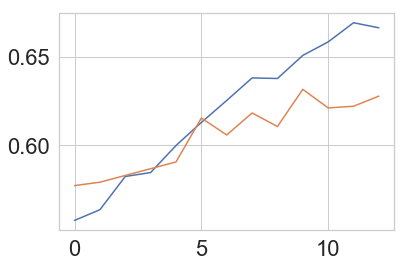

In [138]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])


In [145]:
pred11 = model.predict_proba(xtest_pad, batch_size=500, verbose=1)
pred111 = np.argmax(pred11, axis=1)

pred11.shape

1773/1773 [==============================] - 2s 976us/step


(1773, 21)

In [173]:
pred11 = model.predict_proba(xtest_pad, batch_size=500, verbose=1)
pred111 = np.argmax(pred11, axis=1)
print(pred11.shape)

test4.reset_index(drop=True)
test4['topic'] = pred111
final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
final1 = final1[['save_text','save_title','target']]
final1.columns = sub.columns
final1.head()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Smells Bad
1,I use chia seed in my protein shakes. These ta...,Bad tast,Smells Bad
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Too big to swallow
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Too big to swallow


In [174]:
print(final1.shape)
final1.to_csv('submission/deep1.csv',index=None)

(2553, 3)


In [362]:
try:
    del model
    gc.collect()
except:
    print("no model previously")

# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.8))

model.add(Dense(21, kernel_regularizer=l2(1e-4)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 17, 300)           710400    
_________________________________________________________________
spatial_dropout1d_17 (Spatia (None, 17, 300)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_52 (Dense)             (None, 1024)              308224    
_________________________________________________________________
dropout_35 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_36 (Dropout)         (None, 1024)              0         
__________

In [363]:
from keras.callbacks import EarlyStopping
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])


Train on 4469 samples, validate on 1490 samples
Epoch 1/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.6953 - acc: 0.1804 - val_loss: 2.5068 - val_acc: 0.2698
Epoch 2/50
4469/4469 [==============================] - 6s 1ms/step - loss: 2.4504 - acc: 0.2584 - val_loss: 2.3125 - val_acc: 0.3477
Epoch 3/50
4469/4469 [==============================] - 6s 1ms/step - loss: 2.3225 - acc: 0.3142 - val_loss: 2.2211 - val_acc: 0.3611
Epoch 4/50
4469/4469 [==============================] - 6s 1ms/step - loss: 2.2541 - acc: 0.3256 - val_loss: 2.1455 - val_acc: 0.3732
Epoch 5/50
4469/4469 [==============================] - 6s 1ms/step - loss: 2.2084 - acc: 0.3533 - val_loss: 2.1323 - val_acc: 0.3832
Epoch 6/50
4469/4469 [==============================] - 6s 1ms/step - loss: 2.1647 - acc: 0.3654 - val_loss: 2.0669 - val_acc: 0.3946
Epoch 7/50
4469/4469 [==============================] - 10s 2ms/step - loss: 2.1048 - acc: 0.3853 - val_loss: 2.0603 - val_acc: 0.4060
Epoch 8/50
44

In [147]:
from keras.regularizers import l2

In [152]:
try:
    del model
    gc.collect()
except:
    print("no model previously")

# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding( len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(1e-4))))

model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.8))

model.add(Dense(21, kernel_regularizer=l2(1e-4)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 128, 300)          2409600   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 128, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              615424    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
__________

In [150]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [153]:
epochs = 50

from keras.callbacks import EarlyStopping, ModelCheckpoint
# Fit the model with early stopping callback
modelcheck = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, period=2)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop, modelcheck])


Train on 3157 samples, validate on 1053 samples
Epoch 1/50
3157/3157 [==============================] - 70s 22ms/step - loss: 3.0087 - acc: 0.1378 - val_loss: 2.8429 - val_acc: 0.1899
Epoch 2/50
3157/3157 [==============================] - 67s 21ms/step - loss: 2.8018 - acc: 0.2091 - val_loss: 2.6114 - val_acc: 0.3105
Epoch 3/50
3157/3157 [==============================] - 67s 21ms/step - loss: 2.6159 - acc: 0.2797 - val_loss: 2.4406 - val_acc: 0.3618
Epoch 4/50
3157/3157 [==============================] - 67s 21ms/step - loss: 2.5183 - acc: 0.3101 - val_loss: 2.3235 - val_acc: 0.3808
Epoch 5/50
3157/3157 [==============================] - 67s 21ms/step - loss: 2.4165 - acc: 0.3392 - val_loss: 2.2761 - val_acc: 0.3989
Epoch 6/50
3157/3157 [==============================] - 64s 20ms/step - loss: 2.3898 - acc: 0.3630 - val_loss: 2.2596 - val_acc: 0.4150
Epoch 7/50
3157/3157 [==============================] - 53s 17ms/step - loss: 2.2948 - acc: 0.3760 - val_loss: 2.2151 - val_acc: 0.4160


KeyboardInterrupt: 

In [366]:
try:
    del model
    gc.collect()
except:
    print("no model previously")
    
    
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(21))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 17, 300)           710400    
_________________________________________________________________
spatial_dropout1d_19 (Spatia (None, 17, 300)           0         
_________________________________________________________________
gru_15 (GRU)                 (None, 17, 300)           540900    
_________________________________________________________________
gru_16 (GRU)                 (None, 300)               540900    
_________________________________________________________________
dense_58 (Dense)             (None, 1024)              308224    
_________________________________________________________________
dropout_39 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 1024)              1049600   
__________

In [367]:
from keras.callbacks import EarlyStopping
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])


Train on 4469 samples, validate on 1490 samples
Epoch 1/50
4469/4469 [==============================] - 13s 3ms/step - loss: 2.7085 - acc: 0.1716 - val_loss: 2.5526 - val_acc: 0.2732
Epoch 2/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.5028 - acc: 0.2352 - val_loss: 2.3511 - val_acc: 0.3315
Epoch 3/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.3682 - acc: 0.2998 - val_loss: 2.2801 - val_acc: 0.3423
Epoch 4/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.3073 - acc: 0.3242 - val_loss: 2.2014 - val_acc: 0.3617
Epoch 5/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.2583 - acc: 0.3381 - val_loss: 2.1720 - val_acc: 0.3819
Epoch 6/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.2265 - acc: 0.3394 - val_loss: 2.1587 - val_acc: 0.4067
Epoch 7/50
4469/4469 [==============================] - 9s 2ms/step - loss: 2.1944 - acc: 0.3522 - val_loss: 2.1368 - val_acc: 0.4181
Epoch 8/50
44

In [181]:
from keras.engine.topology import Layer
from keras import backend as K
from keras import initializers, regularizers, constraints, optimizers, layers
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias: eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True)+K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [182]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import Model

from keras.layers import Bidirectional, CuDNNLSTM, LSTM, CuDNNGRU, GRU, Embedding
from keras.layers import Dense, Input, Dropout, Activation, Conv1D, Flatten, Concatenate
from keras.layers import SpatialDropout1D, Dropout, GlobalMaxPooling1D, MaxPooling1D

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ReduceLROnPlateau


In [369]:
try:
    del model
    gc.collect()
except:
    print("no model previously")
    

# GRU with glove embeddings and two dense layers

inp = Input(shape=(max_len,))
x = Embedding(  len(word_index) + 1,
                300,
                weights=[embedding_matrix],
                input_length=max_len,
                trainable=False)(inp)

x = SpatialDropout1D(0.3)(x)
x = GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4))(x)
x = GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4))(x)

x = Attention(max_len)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.8)(x)

x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.8)(x)
x = Dense(21, kernel_regularizer=l2(1e-4))(x)
x = Activation('softmax')(x)

model = Model(inp, x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 17)                0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 17, 300)           710400    
_________________________________________________________________
spatial_dropout1d_20 (Spatia (None, 17, 300)           0         
_________________________________________________________________
gru_17 (GRU)                 (None, 17, 300)           540900    
_________________________________________________________________
gru_18 (GRU)                 (None, 17, 300)           540900    
_________________________________________________________________
attention_5 (Attention)      (None, 300)               317       
_________________________________________________________________
dense_61 (Dense)             (None, 1024)              308224    
__________

In [183]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))

model.add(Attention(max_len))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.8))

model.add(Dense(21, kernel_regularizer=l2(1e-4)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 128, 300)          2409600   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 128, 300)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128, 300)          540900    
_________________________________________________________________
gru_2 (GRU)                  (None, 128, 300)          540900    
_________________________________________________________________
attention_1 (Attention)      (None, 300)               428       
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              308224    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
__________

In [184]:
epochs = 50

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Fit the model with early stopping callback
reducelr = ReduceLROnPlateau(factor=np.sqrt(0.1), monitor='val_loss', patience=2)
modelcheck = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, period=2)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[reducelr, modelcheck, earlystop])


Train on 3157 samples, validate on 1053 samples
Epoch 1/50
3157/3157 [==============================] - 67s 21ms/step - loss: 2.9958 - acc: 0.1277 - val_loss: 2.8163 - val_acc: 0.1500
Epoch 2/50
3157/3157 [==============================] - 64s 20ms/step - loss: 2.8161 - acc: 0.1527 - val_loss: 2.7175 - val_acc: 0.1700
Epoch 3/50
3157/3157 [==============================] - 64s 20ms/step - loss: 2.6513 - acc: 0.2325 - val_loss: 2.4185 - val_acc: 0.3200
Epoch 4/50
3157/3157 [==============================] - 71s 22ms/step - loss: 2.5115 - acc: 0.2860 - val_loss: 2.3221 - val_acc: 0.3713
Epoch 5/50
3157/3157 [==============================] - 67s 21ms/step - loss: 2.4218 - acc: 0.3164 - val_loss: 2.2200 - val_acc: 0.3989
Epoch 6/50
3157/3157 [==============================] - 64s 20ms/step - loss: 2.3703 - acc: 0.3440 - val_loss: 2.1738 - val_acc: 0.4359
Epoch 7/50
3157/3157 [==============================] - 69s 22ms/step - loss: 2.2782 - acc: 0.3782 - val_loss: 2.2286 - val_acc: 0.4387


In [185]:
pred12 = model.predict_proba(xtest_pad, batch_size=500, verbose=1)
pred122 = np.argmax(pred12, axis=1)
print(pred12.shape)

test4.reset_index(drop=True)
test4['topic'] = pred122
final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
final1 = final1[['save_text','save_title','target']]
final1.columns = sub.columns

final1.to_csv('submission/attention_gru.csv', index=None)

final1.head()



1773/1773 [==============================] - 8s 4ms/step
(1773, 21)


,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Smells Bad
1,I use chia seed in my protein shakes. These ta...,Bad tast,Smells Bad
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Pricing
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Pricing


In [208]:
gc.collect()

776

In [209]:
try:
    del model
    gc.collect()
except:
    print("no model previously")
    

# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4))))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4))))

model.add(Attention(max_len))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.8))

model.add(Dense(21, kernel_regularizer=l2(1e-4)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

no model previously
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 128, 300)          2409600   
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 128, 300)          0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128, 600)          1442400   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 128, 600)          2162400   
_________________________________________________________________
attention_9 (Attention)      (None, 600)               728       
_________________________________________________________________
dense_31 (Dense)             (None, 1024)              615424    
_________________________________________________________________
dropout_22 (Dropout)         (None, 1024)              0

In [210]:
epochs = 50

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Fit the model with early stopping callback
reducelr = ReduceLROnPlateau(factor=np.sqrt(0.1), monitor='val_loss', patience=2)
modelcheck = ModelCheckpoint('model_atten_lstm.h5', monitor='val_loss', verbose=0, save_best_only=True, period=2)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[reducelr, modelcheck, earlystop])


Train on 3157 samples, validate on 1053 samples
Epoch 1/50
3157/3157 [==============================] - 172s 54ms/step - loss: 3.1700 - acc: 0.1292 - val_loss: 2.9814 - val_acc: 0.1538
Epoch 2/50
3157/3157 [==============================] - 155s 49ms/step - loss: 2.9948 - acc: 0.1372 - val_loss: 2.9338 - val_acc: 0.1586
Epoch 3/50
3157/3157 [==============================] - 156s 49ms/step - loss: 2.8985 - acc: 0.1720 - val_loss: 2.7319 - val_acc: 0.2877
Epoch 4/50
3157/3157 [==============================] - 156s 49ms/step - loss: 2.7334 - acc: 0.2404 - val_loss: 2.5379 - val_acc: 0.2707
Epoch 5/50
3157/3157 [==============================] - 154s 49ms/step - loss: 2.5757 - acc: 0.3022 - val_loss: 2.3203 - val_acc: 0.3903
Epoch 6/50
3157/3157 [==============================] - 155s 49ms/step - loss: 2.4576 - acc: 0.3424 - val_loss: 2.2944 - val_acc: 0.4055
Epoch 7/50
3157/3157 [==============================] - 153s 49ms/step - loss: 2.4046 - acc: 0.3766 - val_loss: 2.2452 - val_acc: 

In [211]:
pred13 = model.predict_proba(xtest_pad, batch_size=500, verbose=1)
pred133 = np.argmax(pred13, axis=1)
print(pred13.shape)

test4.reset_index(drop=True)
test4['topic'] = pred133
final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
final1 = final1[['save_text','save_title','target']]
final1.columns = sub.columns

final1.to_csv('submission/attention_lstm.csv', index=None)

final1.head()



1773/1773 [==============================] - 22s 13ms/step
(1773, 21)


,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Smells Bad
1,I use chia seed in my protein shakes. These ta...,Bad tast,Smells Bad
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Pricing
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Pricing


In [196]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 128
max_len2 = 17

token.fit_on_texts(list(X_train['text']) + list(X_test['text']))
xtrain_seq = token.texts_to_sequences(X_train['text'])
xvalid_seq = token.texts_to_sequences(X_test['text'])
xtest_seq  = token.texts_to_sequences(test4['text'])

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad  = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

        
# using keras tokenizer here
token1 = text.Tokenizer(num_words=None)

token1.fit_on_texts(list(X_train['title']) + list(X_test['title']))
xtrain_seq1 = token1.texts_to_sequences(X_train['title'])
xvalid_seq1 = token1.texts_to_sequences(X_test['title'])
xtest_seq1  = token1.texts_to_sequences(test4['title'])

# zero pad the sequences
xtrain_pad1 = sequence.pad_sequences(xtrain_seq1, maxlen=max_len2)
xvalid_pad1 = sequence.pad_sequences(xvalid_seq1, maxlen=max_len2)
xtest_pad1  = sequence.pad_sequences(xtest_seq1, maxlen=max_len2)

word_index1 = token1.word_index

# create an embedding matrix for the words we have in the dataset
embedding_matrix1 = np.zeros((len(word_index1) + 1, 300))
for word, i in tqdm(word_index1.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix1[i] = embedding_vector

        
        
ytrain_enc = np_utils.to_categorical(Y_train, num_classes=21)
yvalid_enc = np_utils.to_categorical(Y_test, num_classes=21)

xtrain_pad.shape, xvalid_pad.shape, xtest_pad.shape, xtrain_pad1.shape, xvalid_pad1.shape, xtest_pad1.shape

100%|██████████| 2367/2367 [00:00<00:00, 428759.13it/s]


((3157, 128), (1053, 128), (1773, 128), (3157, 17), (1053, 17), (1773, 17))

In [212]:
try:
    del model_comp
    gc.collect()
except:
    print("no model previously")
    

# GRU with glove embeddings and two dense layers
max_len2 = 17
inp1 = Input(shape=(max_len,))
inp2 = Input(shape=(max_len2,))

x1 = Embedding(  len(word_index) + 1,
                 300,
                 weights=[embedding_matrix],
                 input_length=max_len,
                 trainable=False)(inp1)
x2 = Embedding(  len(word_index1) + 1,
                 300,
                 weights=[embedding_matrix1],
                 input_length=max_len2,
                 trainable=False)(inp2)

x1 = SpatialDropout1D(0.3)(x1)
x2 = SpatialDropout1D(0.3)(x2)

x1 = Bidirectional(LSTM(200, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x1)
x1 = Bidirectional(LSTM(200, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x1)

x2 = Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x2)
x2 = Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x2)

x1 = Attention(max_len)(x1)
x2 = Attention(max_len2)(x2)

x1 = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x1)
x1 = Dropout(0.8)(x1)

x2 = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x2)
x2 = Dropout(0.8)(x2)

x = Concatenate(axis=1)([x1,x2])
x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.8)(x)

x = Dense(21, kernel_regularizer=l2(1e-4))(x)
x = Activation('softmax')(x)

model_comp = Model(input=[inp1, inp2], output=x)
model_comp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_comp.summary()

no model previously
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 128, 300)     2409600     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 17, 300)      710400      input_8[0][0]                    
_________________________________________________________________________________________

In [213]:
epochs = 70

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Fit the model with early stopping callback
reducelr = ReduceLROnPlateau(factor=np.sqrt(0.1), monitor='val_loss', patience=2)
modelcheck = ModelCheckpoint('model_atten_lstm_comb.h5', monitor='val_loss', verbose=0, save_best_only=True, period=2)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model_comp.fit(x=[xtrain_pad, xtrain_pad1], y=ytrain_enc, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=([xvalid_pad, xvalid_pad1], yvalid_enc), callbacks=[reducelr, modelcheck, earlystop])


Train on 3157 samples, validate on 1053 samples
Epoch 1/70
3157/3157 [==============================] - 103s 33ms/step - loss: 3.2174 - acc: 0.1410 - val_loss: 2.9777 - val_acc: 0.1795
Epoch 2/70
3157/3157 [==============================] - 91s 29ms/step - loss: 2.9134 - acc: 0.2075 - val_loss: 2.6858 - val_acc: 0.3048
Epoch 3/70
3157/3157 [==============================] - 91s 29ms/step - loss: 2.6812 - acc: 0.2863 - val_loss: 2.4449 - val_acc: 0.3846
Epoch 4/70
3157/3157 [==============================] - 90s 29ms/step - loss: 2.5118 - acc: 0.3545 - val_loss: 2.3139 - val_acc: 0.4160
Epoch 5/70
3157/3157 [==============================] - 91s 29ms/step - loss: 2.3720 - acc: 0.3966 - val_loss: 2.2234 - val_acc: 0.4729
Epoch 6/70
3157/3157 [==============================] - 91s 29ms/step - loss: 2.2852 - acc: 0.4384 - val_loss: 2.1902 - val_acc: 0.4891
Epoch 7/70
3157/3157 [==============================] - 90s 29ms/step - loss: 2.1899 - acc: 0.4694 - val_loss: 2.0995 - val_acc: 0.5356

In [214]:
pred14 = model_comp.predict([xtest_pad, xtest_pad1], batch_size=100, verbose=1)
pred144 = np.argmax(pred14, axis=1)
print(pred14.shape)

test4.reset_index(drop=True)
test4['topic'] = pred144
final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
final1 = final1[['save_text','save_title','target']]
final1.columns = sub.columns

final1.to_csv('submission/attention_lstm_comb.csv', index=None)

final1.head()



1773/1773 [==============================] - 16s 9ms/step
(1773, 21)


,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
1,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients


In [ ]:
.

In [381]:
xtest_seq = token.texts_to_sequences(df[train.shape[0] : ]['title'])
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
xtest_pad.shape

(2553, 17)

In [384]:
model.history.history['val_acc']

[0.21610738233031843,
 0.2993288591004058,
 0.3402684564958483,
 0.36107382562336504,
 0.38456375814924304,
 0.39127516790524425,
 0.4053691279968159,
 0.4040268461176213,
 0.4248322142450601,
 0.4248322146050882,
 0.42885906088272197,
 0.42885906088272197,
 0.4295302011822694,
 0.4335570474599032,
 0.43624160993819266,
 0.44026845685587634,
 0.4409395974354456,
 0.4456375843726549,
 0.443624160913813,
 0.45100671088935546,
 0.44832214805103787]

In [385]:
pred = model.predict_classes(xtest_pad, batch_size=500)
pred.shape

(2553,)

In [388]:
np.bincount(target)

array([ 567, 1194,  234,    8,  239,   31,  136,   37,    6,   44,  216,
        611,  467,  107,  715,  390,  123,  410,   97,  228,   99])

In [387]:
np.bincount(pred)

array([207, 862,  43,   0,  92,   0,  67,   0,   0,   0,  56, 279, 238,
        26, 225, 151,  38,  84,  45,  88,  52])

In [393]:
pred = pd.DataFrame(data=pred, columns=['target'])
sub1 = pd.concat([test, pred], axis=1)
sub1['topic'] = sub1['target'].apply(lambda x: cl_map_inv[x])

sub1.drop('target', axis=1, inplace=True)
sub1.to_csv('submission/sub2.csv', index=None)

In [399]:
sub1.columns = sub_df.columns
sub1.head()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
1,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Bad Taste/Flavor
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Bad Taste/Flavor


In [398]:
sub_df = pd.read_csv('Dataset/Sample_Submission.csv')
sub_df

,Review Text,Review Title,topic
0,"Not terrible, but not good. Tastes burnt and a...",Not my cup o’ joe,Burnt/ Over -roast
1,"I am so disappointed, it has no flavor, doesn'...","I am so disappointed, it has no flavor",Bad Flavor/Taste
2,"I recently gave up my daily 6 cups of coffee, ...",Flavor was dissapointing,Bitter
3,Meh. I've adored Peruvian coffee for 20 years....,Smooth but majorly bland. Won't repurchase.,NaN
4,Meh. I've adored Peruvian coffee for 20 years....,Smooth but majorly bland. Won't repurchase.,NaN


In [400]:
sub1.to_csv('submission/sub2.csv', index=None)

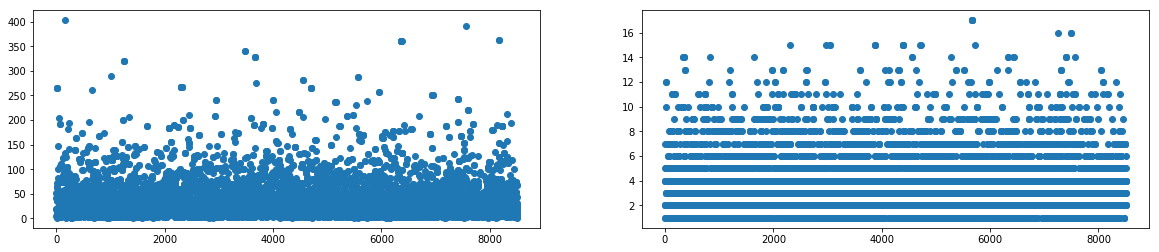

In [14]:
df['wc_text']  = df['text'].apply(lambda x: len(str(x).split(" ")))
df['wc_title'] = df['title'].apply(lambda x: len(str(x).split(" ")))

fig, ax = plt.subplots(1,2,figsize=(20, 4))
ax[0].scatter(range(df.shape[0]), df['wc_text'])
ax[1].scatter(range(df.shape[0]), df['wc_title'])

In [ ]:
# os.makedirs('new_dataset')
# train.to_csv('new_dataset/train1.csv', index=None)
# test.to_csv('new_dataset/test1.csv', index=None)
train.shape, test.shape

In [15]:
def get_quantile(df, col, q1, q2):
    """compute quantile range
    args:
        col: col name
        q1: lower quantile percentile
        q2: upper quantile percentile
    """
    df1 = df[[col]].dropna()
    lower_bound = np.percentile(df1, q=q1)
    upper_bound = np.percentile(df1, q=q2)
    lower_bound = np.round(lower_bound,3)
    upper_bound = np.round(upper_bound, 3)
    min_ = np.round(np.min(df1[col]), 3)
    max_ = np.round(np.max(df1[col]), 3)
    print("Col: {4:<10} min: {0:<10} max: {1:<10} low: {2:<10} high: {3:<10}".format(min_, max_, lower_bound, upper_bound, col))

get_quantile(df, 'wc_text', 1, 95)
get_quantile(df, 'wc_title', 1, 95)

get_quantile(df, 'wc_text', 1, 97)
get_quantile(df, 'wc_title', 1, 97)

get_quantile(df, 'wc_text', 1, 99)
get_quantile(df, 'wc_title', 1, 99)


Col: wc_text    min: 1          max: 403        low: 2.0        high: 119.0     
Col: wc_title   min: 1          max: 17         low: 1.0        high: 8.0       
Col: wc_text    min: 1          max: 403        low: 2.0        high: 144.0     
Col: wc_title   min: 1          max: 17         low: 1.0        high: 10.0      
Col: wc_text    min: 1          max: 403        low: 2.0        high: 196.0     
Col: wc_title   min: 1          max: 17         low: 1.0        high: 12.0      


In [16]:
from keras.engine.topology import Layer
from keras import backend as K
from keras import initializers, regularizers, constraints, optimizers, layers
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias: eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True)+K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


Using TensorFlow backend.


In [ ]:
# from keras.models import Model
# from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
# from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D

# max_features = 50000
# num_classes  = 21
# max_words    = 200
# filter_sizes = [1,2,3,5]
# num_filters  = 36
# inp = Input(shape=(max_words,))
# x = Embedding(max_features, 300, trainable=False)(inp)
# x = Reshape((max_words, 300, 1))(x)
# maxpool_pool = []
# for i in range(len(filter_sizes)):
#     conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], 300),
#                                  kernel_initializer='he_normal', activation='relu')(x)
#     maxpool_pool.append(MaxPool2D(pool_size=(max_words - filter_sizes[i] + 1, 1))(conv))
# z = Concatenate(axis=1)(maxpool_pool)   
# z = Flatten()(z)
# z = Dropout(0.1)(z)
# outp = Dense(num_classes, activation="softmax")(z)
# model = Model(inputs=inp, outputs=outp)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [17]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import Model

from keras.layers import Bidirectional, CuDNNLSTM, LSTM, CuDNNGRU, GRU, Embedding
from keras.layers import Dense, Input, Dropout, Activation, Conv1D, Flatten, Concatenate
from keras.layers import SpatialDropout1D, Dropout, GlobalMaxPooling1D, MaxPooling1D

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ReduceLROnPlateau


In [18]:
len(embeddings_index)

400000

In [19]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(list(df['text']))
word_index1 = tokenizer1.word_index

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(list(df['title']))
word_index2 = tokenizer2.word_index

len(word_index1), len(word_index2)

(9387, 2830)

In [20]:
max_features1 = len(word_index1) + 1
max_features2 = len(word_index2) + 1

max_words1 = 200
max_words2 = 17

text = tokenizer1.texts_to_sequences(df['text'])
text = pad_sequences(text, maxlen = max_words1)

title = tokenizer2.texts_to_sequences(df['title'])
title = pad_sequences(title, maxlen = max_words2)

text.shape, title.shape

((8512, 200), (8512, 17))

In [21]:
batch_size   = 32
epochs       = 40
num_classes  = 21


In [23]:
inp1 = Input(shape=(max_words1,))
inp2 = Input(shape=(max_words2,))

x1 = Embedding(max_features1, 300, trainable=True)(inp1)
x2 = Embedding(max_features2, 300, trainable=True)(inp2)

x1 = Bidirectional(LSTM(128, return_sequences=True))(x1)
x1 = Bidirectional(LSTM(64, return_sequences=True))(x1)
x1 = Attention(max_words1)(x1)

x2 = Bidirectional(LSTM(64, return_sequences=True))(x2)
x2 = Bidirectional(LSTM(32, return_sequences=True))(x2)
x2 = Attention(max_words2)(x2)

x1, x2

(<tf.Tensor 'attention_3/Sum_1:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'attention_4/Sum_1:0' shape=(?, 64) dtype=float32>)

In [24]:
x = Concatenate(axis=-1)([x1, x2])
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dense(num_classes, activation="softmax")(x)
modelATT = Model(inputs=[inp1, inp2], outputs=x)
modelATT.compile(loss='categorical_crossentropy', 
                 optimizer=Adam(lr=1e-2), metrics=['accuracy'])
modelATT.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 300)     2816400     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 17, 300)      849300      input_4[0][0]                    
__________________________________________________________________________________________________
bidirectio

In [25]:
tr_len = train.shape[0]
ts_len = test.shape[0]
# train.shape[0] + test.shape[0], df.shape[0]
train1 = df.iloc[:tr_len]
test1  = df.iloc[tr_len:]
train1.shape, test.shape

((5959, 5), (2553, 2))

In [26]:
def get_mapping(df, col_name):
    cat_codes = df[col_name].astype('category')
    
    class_mapping = {}
    i = 0
    for col in cat_codes.cat.categories:
        class_mapping[col] = i
        i += 1
    
    class_mapping_reverse = {}
    for key, value in class_mapping.items():
        class_mapping_reverse[value] = key

    return class_mapping, class_mapping_reverse

cl_map, cl_map_inv = get_mapping(train1, 'topic')

In [27]:
train1['target'] = train1['topic'].astype('category').cat.codes
train1['target'] = train1['target'].astype('int')

text_title = np.concatenate([text, title], axis=1)
tr_text_title = text_title[:tr_len]
ts_text_title = text_title[tr_len:]
print(tr_text_title.shape, ts_text_title.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    tr_text_title, train1['target'], shuffle=True,
    stratify=train1['target'], test_size=0.3, random_state=1337
)
X_train.shape, Y_train.shape

(5959, 217) (2553, 217)


((4171, 217), (4171,))

In [28]:
X_tr_text  = X_train[:,:200]
X_tr_title = X_train[:,200:]

X_ts_text  = X_test[:,:200]
X_ts_title = X_test[:,200:]

X_tr_text.shape, X_tr_title.shape, X_ts_text.shape, X_ts_title.shape 

((4171, 200), (4171, 17), (1788, 200), (1788, 17))

In [29]:
from keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes=num_classes)
Y_test  = to_categorical(Y_test, num_classes=num_classes)
Y_train.shape, Y_test.shape

((4171, 21), (1788, 21))

In [30]:
from sklearn.utils import class_weight
def get_class_weights(y):
    """ 
    Example:
        model.fit(X_t, y, batch_size=10, epochs=2,validation_split=0.1,sample_weight=sample_wts)
    
    """
    return class_weight.compute_sample_weight('balanced', y)

cls_wts = get_class_weights(Y_train)
cls_wts

array([1.60750658e-05, 1.85060810e-05, 1.85060810e-05, ...,
       1.95252374e-05, 1.60750658e-05, 5.45514998e-06])

In [31]:
cls_wts.shape

(4171,)

In [34]:
modelATT.compile(loss='categorical_crossentropy', 
                 optimizer=Adam(lr=1e-2), metrics=['accuracy'])

In [35]:
%%time
early_stop = EarlyStopping(monitor="val_acc", patience=1, verbose=1)
history    = modelATT.fit(
    [X_tr_text, X_tr_title], Y_train,
    validation_data = ([X_ts_text, X_ts_title], Y_test),
    epochs          = epochs,
    batch_size      = batch_size,
    verbose         = 1,
    sample_weight   = cls_wts,
    callbacks       = [early_stop]
)

Train on 4171 samples, validate on 1788 samples
Epoch 1/40
4171/4171 [==============================] - 113s 27ms/step - loss: 8.4009e-05 - acc: 0.0173 - val_loss: 3.0743 - val_acc: 0.0358
Epoch 2/40
4171/4171 [==============================] - 103s 25ms/step - loss: 8.3744e-05 - acc: 0.0254 - val_loss: 3.0808 - val_acc: 0.0229
Epoch 00002: early stopping
CPU times: user 11min 22s, sys: 58.9 s, total: 12min 21s
Wall time: 3min 42s


In [ ]:
import gc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

def tfidf_feature(train, test, col_name, min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=120, decom_flag=False, which_method='svd', 
                  max_features=None):
    """return tfidf feature
    Args:
        train, test: dataframe
        col_name: column name of text feature
        min_df: if Int, then it represent count of the minimum words in corpus (remove very rare word)
        analyzer: [‘word’, ‘char’]
        ngram: max range of ngram
        token_pattern: [using: r'\w{1,}'] [by default: '(?u)\b\w\w+\b']
        stopwords: ['english' or customized by remove specific words]
        n_component: n_component of svd feature transform
        decom_flag: Wheteher to run svd/nmf on top of that or not (by default: False)
        which_method: which to run [svd or nmf] on top of tfidf (by default: False)
        max_features: max no of features to keep, based on frequency. It will keep words with higher freq
    return:
        Transformed feature space of the text data, as well as tfidf function instance
        if svd_flag== True : train_tf, test_tf, tfv, svd
        else : train_tf, test_tf, tfv
    example:
        train_tfv, test_tfv, tfv = tfidf_feature(X_train, X_test, ['text'], min_df=3)
        train_svd, test_svd, complete_tfv, tfv, svd = tfidf_feature(X_train, X_test, ['text'], 
            min_df=3, svd_component=3, svd_flag=True)

    """
    tfv = TfidfVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, max_df=1.0, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                use_idf=1, smooth_idf=1, sublinear_tf=1,
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
#         return complete_df
#         print(complete_df.shape, complete_df.columns)

    tfv.fit(list(complete_df[:].values))

    if decom_flag is False:
        train_tfv =  tfv.transform(train[col_name].values.ravel()) 
        test_tfv  = tfv.transform(test[col_name].values.ravel())

        del complete_df
        gc.collect()
        return train_tfv, test_tfv, tfv
    else:
        complete_tfv = tfv.transform(complete_df[:].values.ravel())
        
        if which_method is 'svd':
            svd = TruncatedSVD(n_components=n_component)
            svd.fit(complete_tfv)
            complete_dec = svd.transform(complete_tfv)
        else:
            nmf = NMF(n_components=n_component, random_state=1234, alpha=0, l1_ratio=0)
            nmf.fit(complete_tfv)            
            complete_dec = nmf.fit_transform(complete_tfv)            
        
        
        complete_dec = pd.DataFrame(data=complete_dec)
        complete_dec.columns = [which_method+'_'+str(i) for i in range(n_component)]

        train_dec = complete_dec.iloc[:train.shape[0]]
        test_dec = complete_dec.iloc[train.shape[0]:].reset_index(drop=True)

        del complete_dec, complete_df
        gc.collect()
        return train_dec, test_dec, complete_tfv, tfv

def countvect_feature(train, test, col_name, min_df=3, analyzer='word', token_pattern=r'\w{1,}', ngram=3, stopwords='english', max_features=None):
    """return CountVectorizer feature
    Args:
        train, test: dataset
        col_name: columns name of the text feature
        min_df: if Int, then it represent count of the minimum words in corpus (remove very rare word)
        analyzer: [‘word’, ‘char’]
        ngram: max range of ngram
        token_pattern: [using: r'\w{1,}'] [by default: '(?u)\b\w\w+\b']
        stopwords: ['english' or customized by remove specific words]
        max_features: max no of features to keep, based on frequency. It will keep words with higher freq
    return:
        Count feature space of the text data, as well as its function instance
    """
    ctv = CountVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
    ctv.fit(list(complete_df[:].values))

    train_tf =  ctv.transform(train[col_name].values.ravel()) 
    test_tf  = ctv.transform(test[col_name].values.ravel())

    del complete_df
    gc.collect()
    return train_tf, test_tf, ctv


In [ ]:
out_tfidfs = []
for ngram in [1,2,3,4,5]:
    out_tfidfs.append(tfidf_feature(train, test, ''))

In [ ]:
out_tfidf1 = tfidf_feature(train, test, 'text', ngram=1)
out_tfidf2 = tfidf_feature(train, test, 'text', ngram=2)
out_tfidf3 = tfidf_feature(train, test, 'text', ngram=3)
out_tfidf4 = tfidf_feature(train, test, 'text', ngram=5)

out_vect1 = countvect_feature(train, test, 'text', ngram=1)
out_vect2 = countvect_feature(train, test, 'text', ngram=2)
out_vect3 = countvect_feature(train, test, 'text', ngram=3)
out_vect4 = countvect_feature(train, test, 'text', ngram=5)

print('tf-idf features: ', out_tfidf1[0].shape, 
     out_tfidf2[0].shape, out_tfidf3[0].shape, out_tfidf4[0].shape)
print('count-vect features: ', out_vect1[0].shape, 
     out_vect2[0].shape, out_vect3[0].shape, out_vect4[0].shape)


## Multinomial bayes classifier

In [ ]:
train['target'] = train['topic'].astype('category').cat.codes
train['target'] = train['target'].astype('int')
all_class = list(train['target'].unique())
print(len(all_class))

In [ ]:
train[train['target'] == 1].shape, out_tfidf1.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf1[0], train['target'], stratify=train['target'], test_size=0.3
)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, Y_train)
# pred = clf.predict(X_test)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf1[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("tfidf1 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf2[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("tfidf2 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf3[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("tfidf3 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf4[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("tfidf4 : ", clf.score(X_test, Y_test))

print("=="*25)

from sklearn.naive_bayes import MultinomialNB
X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect1[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("count-vect1 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect2[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("count-vect2 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect3[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("count-vect3 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect4[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("count-vect4 : ", clf.score(X_test, Y_test))


In [ ]:
logistic_reg = LogisticRegression(penalty='l2', dual=False, 
    C=0.01, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)
logistic_reg.fit(X_train, Y_train)
print(logistic_reg.score(X_test, Y_test))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import MultinomialNB
X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf1[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("tfidf1 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf2[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("tfidf2 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf3[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("tfidf3 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf4[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("tfidf4 : ", logistic_reg.score(X_test, Y_test))

print("=="*25)

from sklearn.naive_bayes import MultinomialNB
X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect1[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("count-vect1 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect2[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("count-vect2 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect3[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("count-vect3 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect4[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("count-vect4 : ", logistic_reg.score(X_test, Y_test))


In [ ]:
sub_df = pd.read_csv('Dataset/Sample_Submission.csv')
sub_df

In [ ]:
logistic_reg.fit(out_vect3[0], train['target'])
pred = logistic_reg.predict(out_vect3[1])
pred.shape

In [ ]:
# def category_encoder(df)
test.drop('topic', axis=1, inplace=True)
test['target'] = pred
test.head()

In [ ]:
test['topic'] = test['target'].apply(lambda x: class_mapping_reverse[str(x)])

In [ ]:
test.drop('target', axis=1, inplace=True)
# os.makedirs('submission')
test.to_csv('submission/linear_model1.csv', index=None)

In [ ]:
def get_mapping(df, col_name):
    cat_codes = df[col_name].astype('category')
    
    class_mapping = {}
    i = 0
    for col in cat_codes.cat.categories:
        class_mapping[col] = i
        i += 1
    
    class_mapping_reverse = {}
    for key, value in class_mapping.items():
        class_mapping_reverse[value] = key

    return class_mapping, class_mapping_reverse

In [ ]:
class_mapping, class_mapping_reverse = get_mapping(train, 'topic')

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier

params = {}
params['alpha'] = 1
passive_agg = PassiveAggressiveClassifier(C=params['alpha'], early_stopping=False, validation_fraction=0.3, n_iter_no_change=5, shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='hinge', class_weight='balanced', average=False, n_iter=None)
ridge_clf = RidgeClassifier(alpha=params['alpha'], fit_intercept=True, normalize=True, class_weight='balanced', random_state=1234)
logistic_reg = LogisticRegression(penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

In [ ]:
ridge_clf.fit(X_train, Y_train)
print(ridge_clf.score(X_test, Y_test))
print("==============")

passive_agg.fit(X_train, Y_train)
print(passive_agg.score(X_test, Y_test))
print("==============")

logistic_reg.fit(X_train, Y_train)
print(logistic_reg.score(X_test, Y_test))
print("==============")


In [ ]:
from sklearn.metrics import f1_score

for alpha in [0.01, 0.1, 0.5, 1, 5, 10]:
    logistic_reg = LogisticRegression(penalty='l2', dual=False, 
        C=alpha, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
        random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)
    logistic_reg.fit(X_train, Y_train)
    pred = logistic_reg.score(X_test, Y_test)
    print(pred)
#     print(f1_score(ts_y, pred, average='micro', sample_weight=None))
#     print(logistic_reg.score(ts_x, ts_y))
print("==============")

In [ ]:
for alpha in np.linspace(0.0001,0.1,10):
    logistic_reg = LogisticRegression(penalty='l2', dual=False, 
        C=alpha, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
        random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)
    logistic_reg.fit(X_train, Y_train)
    pred = logistic_reg.score(X_test, Y_test)
    print(alpha, " : ", pred)

In [ ]:
Usage: plot_document_classification_20newsgroups.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
data loaded
2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories

Extracting features from the training data using a sparse vectorizer
done in 0.412178s at 9.655MB/s
n_samples: 2034, n_features: 33809

Extracting features from the test data using the same vectorizer
done in 0.351330s at 8.162MB/s
n_samples: 1353, n_features: 33809

================================================================================
Ridge Classifier
________________________________________________________________________________
Training:
RidgeClassifier(solver='sag', tol=0.01)
train time: 0.132s
test time:  0.001s
accuracy:   0.896
dimensionality: 33809
density: 1.000000


================================================================================
Perceptron
________________________________________________________________________________
Training:
Perceptron(max_iter=50)
train time: 0.017s
test time:  0.002s
accuracy:   0.888
dimensionality: 33809
density: 0.255302


================================================================================
Passive-Aggressive
________________________________________________________________________________
Training:
PassiveAggressiveClassifier(max_iter=50)
train time: 0.031s
test time:  0.002s
accuracy:   0.904
dimensionality: 33809
density: 0.694674


================================================================================
kNN
________________________________________________________________________________
Training:
KNeighborsClassifier(n_neighbors=10)
train time: 0.002s
test time:  0.317s
accuracy:   0.858

================================================================================
Random forest
________________________________________________________________________________
Training:
RandomForestClassifier(n_estimators=100)
train time: 1.671s
test time:  0.071s
accuracy:   0.840

================================================================================
L2 penalty
________________________________________________________________________________
Training:
LinearSVC(dual=False, tol=0.001)
train time: 0.145s
test time:  0.002s
accuracy:   0.900
dimensionality: 33809
density: 1.000000


________________________________________________________________________________
Training:
SGDClassifier(max_iter=50)
train time: 0.030s
test time:  0.002s
accuracy:   0.902
dimensionality: 33809
density: 0.579380


================================================================================
L1 penalty
________________________________________________________________________________
Training:
LinearSVC(dual=False, penalty='l1', tol=0.001)
train time: 0.301s
test time:  0.002s
accuracy:   0.873
dimensionality: 33809
density: 0.005553


________________________________________________________________________________
Training:
SGDClassifier(max_iter=50, penalty='l1')
train time: 0.093s
test time:  0.002s
accuracy:   0.887
dimensionality: 33809
density: 0.022901


================================================================================
Elastic-Net penalty
________________________________________________________________________________
Training:
SGDClassifier(max_iter=50, penalty='elasticnet')
train time: 0.252s
test time:  0.002s
accuracy:   0.899
dimensionality: 33809
density: 0.187472


================================================================================
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training:
NearestCentroid()
train time: 0.004s
test time:  0.002s
accuracy:   0.855

================================================================================
Naive Bayes
________________________________________________________________________________
Training:
MultinomialNB(alpha=0.01)
train time: 0.003s
test time:  0.001s
accuracy:   0.899
dimensionality: 33809
density: 1.000000


________________________________________________________________________________
Training:
BernoulliNB(alpha=0.01)
train time: 0.004s
test time:  0.003s
accuracy:   0.884
dimensionality: 33809
density: 1.000000


________________________________________________________________________________
Training:
ComplementNB(alpha=0.1)
train time: 0.004s
test time:  0.001s
accuracy:   0.911
dimensionality: 33809
density: 1.000000


================================================================================
LinearSVC with L1-based feature selection
________________________________________________________________________________
Training:
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1',
                                                     tol=0.001))),
                ('classification', LinearSVC())])
train time: 0.252s
test time:  0.002s
accuracy:   0.880

In [ ]:
# tf_train[i] # feature count vector for training case i
# y_train[i] # label for training case i

# The count vectors are defined as:

# p = sum of all feature count vectors with label 1

# p = tf_train[y_train==1].sum(0) + 1

# q = sum of all feature count vectors with label 0

# q = tf_train[y_train==0].sum(0) + 1

# Notice that we add 1 to both count vectors to ensure that every token appear at least one time in each class.

# The log-count ratio r is:

# r = np.log((p/p.sum()) / (q/q.sum()))

# And b:

# b = np.log(len(p) / len(q))

# Just the ratio of number of positive and negative training cases.

In [ ]:
pre_preds = tf_test @ r.T + b
preds = pre_preds.T > 0
accuracy = (preds == y_test).mean()

In [ ]:
out_tfidf1[0][train['target'] == 5].sum(0)

In [ ]:
out_tfidf1[0][train['target'] == 4].sum(0)

In [ ]:
np.sum(np.equal(out_tfidf1[0][train['target'] == 5].sum(0), 
                out_tfidf1[0][train['target'] == 3].sum(0)))

In [ ]:
out_tfidf1[0][train['target'] == 5].shape

In [ ]:
out_tfidf1[0][train['target'] == 2].shape

In [ ]:
idx = train[train['target'] == 2].index

In [ ]:
out_tfidf1[0][idx].sum(0)

In [ ]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

# train['text1'] = train['text'].progress_apply(lemmatization)
# test['text1']  = test['text'].progress_apply(lemmatization)


In [ ]:
df = train.append(test, ignore_index=True)
df['text1'] = df['text'].apply(lemmatization)

In [ ]:
df[:5]['text'].apply(lemmatization)

In [ ]:
df1

In [ ]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]



In [ ]:
df1['text'].apply(lemmatize_text)

In [ ]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(text):
    return []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output


In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


In [ ]:
# word_tokenize(df1['text'][4])

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

porter=PorterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

porter=PorterStemmer()
porter.stem('helping')

In [ ]:
for word in df1['text'][1].split(" "):
    print(porter.stem(word))

In [ ]:
import gc
del df1, df
gc.collect()

In [ ]:
df = train.append(test, ignore_index=True)
df.shape

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

cv = CountVectorizer(max_df=0.95,min_df=2,stop_words='english')
term_matrix = cv.fit_transform(df['text'])
# print(term_matrix)

In [ ]:
lda = LatentDirichletAllocation(n_components=5, n_jobs=4)
lda.fit(term_matrix)


In [ ]:
gc.collect()

In [ ]:
lda.components_[0]

In [ ]:
topic = lda.components_[0]
top_words_indices = topic.argsort()[-10:]
for index in top_words_indices:
    print(cv.get_feature_names()[index])

In [ ]:
topic_word_dict = {}
for index,topic in enumerate(lda.components_):
    words = [cv.get_feature_names()[i] for i in topic.argsort()[-10:]]
    topic_word_dict[index] = words
    print('Top words for topic {}'.format(index))
    print(words)
    print('-'*120)


In [ ]:

topics = lda.transform(term_matrix)
data['topic'] = topics.argmax(axis=1)


def assign_topics(row):
    topic = row['topic']
    words = topic_word_dict[topic]

    return words


data['topic words'] = data.apply(assign_topics,axis=1)
print(data.head())

